In [1]:
# Import main packages
import sys, os
sys.path.insert(1, os.path.abspath('..') )
from ECO import diagnostics as eco
from ECO.utils import config_parser, open_datasets, get_namelist
import xarray as xr
import xgcm
import numpy as np

# Import matplotlib for plotting and functions to override default values
import matplotlib.pyplot as plt
from plot_utils import update_plotstyle, cmap_OB
cmap_OB=cmap_OB(); update_plotstyle()

In [2]:
exp_prefix = ['EXP00','EXP01'] # Import all files with this prefix
exp_suffix = ['_rest6m2000_1','_rest6m2000_1']
ds = open_datasets(exp_prefix, exp_suffix, components = ['all'])
if type(ds) != dict: 
    ds={exp_prefix+exp_suffix:ds}
exp_names = [exp_prefix[i]+exp_suffix[i] for i in range(len(exp_prefix))]

In [3]:
# get base configuration of EXP00
kwargs={}
#kwargs[exp_prefix+exp_suffix] = config_parser(exp_prefix)
for i in range(len(exp_prefix)): kwargs[exp_prefix[i]+exp_suffix[i]] = config_parser(exp_prefix[i])
#for exp in exp_suffix: kwargs[exp_prefix+exp] = config_parser(exp_prefix)
#if kwargs_sim['get_namelist']: kwargs_sim['namelist'] = get_namelist(path = kwargs_proc['path_nemo'])

# define xgcm configuration based on dataset metrics
_metrics = {('X',): ['e1tm', 'e1um', 'e1vm', 'e1fm'],
     ('Y',): ['e2tm', 'e2um', 'e2vm', 'e2fm'],
     ('Z',): ['e3tm', 'e3um', 'e3vm', 'e3wm']}

grid = {exp: xgcm.Grid(ds[exp], metrics=_metrics, periodic=False) for exp in ds} # define xgcm grid
grid_ops = {exp: eco.Grid_ops(grid[exp], maskargs={'mask':'nan'}) for exp in ds} # define gridoperations.
grid = {exp: grid_ops[exp]._update({'Z':ds[exp]['e3tm_1d']}) for exp in ds}
        
properties= {exp: eco.Properties(grid_ops[exp], {'X': ds[exp].glamt, 'Y': ds[exp].gphit, 'Z': ds[exp].depth_1d}, eos_properties=kwargs[exp][2]['eos']) for exp in ds}
energetics= {exp: eco.Energetics(grid_ops[exp], properties[exp]) for exp in ds}

Using processing configuration base.yml
Using processing configuration base.yml


In [4]:
exp_conv = ['EXP00_rest6m2000_1','EXP01_rest6m2000_1']
ttrd_zdf_qns = {exp: ds[exp].ttrd_zdf.copy() for exp in exp_conv}
ttrd_qns = {}
strd_cdt = {}
for exp in exp_conv:
    qns_3d = xr.zeros_like(ds[exp].ttrd_zdf)
    qns_3d[:,0] += ds[exp].ttrd_qns

    ttrd_zdf_qns[exp] += qns_3d
    ttrd_qns[exp] = qns_3d

    cdt_3d = xr.zeros_like(ds[exp].ttrd_zdf)
    cdt_3d[:,0] += ds[exp].strd_cdt
    strd_cdt[exp] = cdt_3d

In [5]:

F_tzdf_w = {exp: grid[exp].cumint(ds[exp].ttrd_zdf,'Z',boundary='fill',fill_value=0).compute() for exp in exp_names}
F_szdf_w = {exp: grid[exp].cumint(ds[exp].strd_zdf,'Z',boundary='fill',fill_value=0).compute() for exp in exp_names}

In [6]:
# Integration by hand to obtain downward flux

FT_bot_to_top = {exp: np.nan*np.ones(ds[exp].e3wm.shape) for exp in ds}
FS_bot_to_top = {exp: np.nan*np.ones(ds[exp].e3wm.shape) for exp in ds}
FT_surfaceflux = {exp: np.ones(ds[exp].e3wm[:,0].shape) for exp in ds}
FS_surfaceflux = {exp: np.ones(ds[exp].e3wm[:,0].shape) for exp in ds}

#FS_bot_to_top_plus_sf = {exp: np.nan*np.ones(ds[exp].e3wm.shape) for exp in ds}
for exp in ds:
    I = ds[exp].z_c.size
    QT = (ds[exp].ttrd_zdf*ds[exp].e3tm).values#*ds[exp].e2tm*ds[exp].e1tm).values
    QS = (ds[exp].strd_zdf*ds[exp].e3tm).values#*ds[exp].e2tm*ds[exp].e1tm).values

    for i in range(1, I):
        if i==1:
            FT_bot_to_top[exp][:,-1-i] = QT[:,-1-i]
            FS_bot_to_top[exp][:,-1-i] = QS[:,-1-i]
        elif i==I-1:
            FT_bot_to_top[exp][:,-1-i] = QT[:,0]*0# + QT[:,-1-i])
            FS_bot_to_top[exp][:,-1-i] = QS[:,0]*0# + QS[:,-1-i])
            FT_surfaceflux[exp] = (FT_bot_to_top[exp][:,1] + QT[:,0]) + (ds[exp].ttrd_qns.values+ds[exp].ttrd_qsr[:,0].values)*ds[exp].e3tm[:,0].values
            FS_surfaceflux[exp] = (FS_bot_to_top[exp][:,1] + QS[:,0]) + ds[exp].strd_cdt.values*ds[exp].e3tm[:,0].values
            #FT_bot_to_top_plus_sf[exp][:,0] = FT_bot_to_top[exp][:,0]+QT[:,0]+ds[exp].ttrd_qns.values
            #FS_bot_to_top[exp][:,0] = FT_bot_to_top[exp][:,0]+QS[:,0]+ds[exp].ttrd_cdt.values
        else:
            FT_bot_to_top[exp][:,-1-i] = (FT_bot_to_top[exp][:,-i] + QT[:,-1-i])
            FS_bot_to_top[exp][:,-1-i] = (FS_bot_to_top[exp][:,-i] + QS[:,-1-i])
    FT_bot_to_top[exp] = xr.DataArray(FT_bot_to_top[exp], coords=ds[exp].e3wm.coords)
    FS_bot_to_top[exp] = xr.DataArray(FS_bot_to_top[exp], coords=ds[exp].e3wm.coords)
    FT_surfaceflux[exp] = xr.DataArray(FT_surfaceflux[exp], coords=ds[exp].e3wm[:,0].coords)
    FS_surfaceflux[exp] = xr.DataArray(FS_surfaceflux[exp], coords=ds[exp].e3wm[:,0].coords)
#F_tzdf_w = {exp: grid[exp].cumint(ds[exp].ttrd_zdf,'Z',boundary='fill',fill_value=0).compute() for exp in exp_conv}
#F_szdf_w = {exp: grid[exp].cumint(ds[exp].strd_zdf,'Z',boundary='fill',fill_value=0).compute() for exp in exp_conv}

In [7]:
mask_avt= {exp: (grid_ops[exp].nan_mask(ds[exp].k_evd)*ds[exp].k_evd/100).compute() for exp in ds}
mask_avt_invert={exp: ((ds[exp].mask_bd_w)*((-(mask_avt[exp]-1)).fillna(1))).compute() for exp in ds}

In [8]:
dh_T = {exp: properties[exp].dh_T(ds[exp].to,ds[exp].so,ds[exp].depth,Z_r=ds[exp].zg_0).compute() for exp in ds}
dh_S = {exp: properties[exp].dh_S(ds[exp].to,ds[exp].so,ds[exp].depth,Z_r=ds[exp].zg_0).compute() for exp in ds}
dhTdz = {exp: grid[exp].derivative(dh_T[exp],'Z',boundary='fill',fill_value=0).compute() for exp in ds}
dhSdz = {exp: grid[exp].derivative(dh_S[exp],'Z',boundary='fill',fill_value=0).compute() for exp in ds}
#dhTdz1 = {exp: grid[exp].derivative(dh_T[exp],'Z',boundary='extrapolate').compute() for exp in exp_conv}
#dhSdz1 = {exp: grid[exp].derivative(dh_S[exp],'Z',boundary='extrapolate').compute() for exp in exp_conv}

# dh_T0 = {exp: properties[exp].dh_T(ds[exp].t_gm,ds[exp].s_gm,ds[exp].depth,Z_r=ds[exp].zg_0).compute() for exp in ds}
# dh_S0 = {exp: properties[exp].dh_S(ds[exp].t_gm,ds[exp].s_gm,ds[exp].depth,Z_r=ds[exp].zg_0).compute() for exp in ds}
# dhTdz0 = {exp: grid[exp].derivative(dh_T0[exp],'Z',boundary='fill',fill_value=0).compute() for exp in ds}
# dhSdz0 = {exp: grid[exp].derivative(dh_S0[exp],'Z',boundary='fill',fill_value=0).compute() for exp in ds}

In [9]:
# Computation of KN2_diffusive and KN2_convective

KN2_h_bot_to_top_convective = {exp: - (dhTdz[exp]*FT_bot_to_top[exp]*mask_avt[exp].fillna(0) +  dhSdz[exp]*FS_bot_to_top[exp]*mask_avt[exp].fillna(0)).compute()
                     for exp in ds}
KN2_h_bot_to_top_convective_gm = {exp: properties[exp].global_mean(KN2_h_bot_to_top_convective[exp],Vmask=ds[exp].mask_bd_w).compute() for exp in ds}

KN2_h_bot_to_top_diffusive = {exp: - (dhTdz[exp]*FT_bot_to_top[exp]*mask_avt_invert[exp].fillna(0) + dhSdz[exp]*FS_bot_to_top[exp]*mask_avt_invert[exp].fillna(0)).compute() 
                           for exp in ds}
KN2_h_bot_to_top_diffusive_gm = {exp: properties[exp].global_mean(KN2_h_bot_to_top_diffusive[exp],Vmask=ds[exp].mask_bd_w).compute() for exp in ds}

# Mean state

# KN2_h_bot_to_top_convective0 = {exp: - (dhTdz0[exp]*FT_bot_to_top[exp]*mask_avt[exp].fillna(0) +  dhSdz0[exp]*FS_bot_to_top[exp]*mask_avt[exp].fillna(0)).compute()
#                      for exp in ds}
# KN2_h_bot_to_top_convective_gm0 = {exp: properties[exp].global_mean(KN2_h_bot_to_top_convective0[exp],Vmask=ds[exp].mask_bd_w).compute() for exp in ds}

# KN2_h_bot_to_top_diffusive0 = {exp: - (dhTdz0[exp]*FT_bot_to_top[exp]*mask_avt_invert[exp].fillna(0) + dhSdz0[exp]*FS_bot_to_top[exp]*mask_avt_invert[exp].fillna(0)).compute() 
#                            for exp in ds}
# KN2_h_bot_to_top_diffusive_gm0 = {exp: properties[exp].global_mean(KN2_h_bot_to_top_diffusive0[exp],Vmask=ds[exp].mask_bd_w).compute() for exp in ds}

: 

In [ ]:
# Computation of Surface Flux contribution (qns, cdt, qsr[0], zdf[0])
V_full = {exp: (ds[exp].e3tm*ds[exp].e2tm*ds[exp].e1tm).sum(['z_c','y_c','x_c']).compute() for exp in ds}
GhT_surfaceflux, GhS_surfaceflux, GhT_surfaceflux2d, GhS_surfaceflux2d =  {}, {}, {}, {}
for exp in ds:
    GhT_surfaceflux[exp] = 1/V_full[exp]*(dh_T[exp][:,0]*FT_surfaceflux[exp]*ds[exp].e2tm*ds[exp].e1tm).sum(['y_c','x_c']).compute()
    GhS_surfaceflux[exp] = 1/V_full[exp]*(dh_S[exp][:,0]*FS_surfaceflux[exp]*ds[exp].e2tm*ds[exp].e1tm).sum(['y_c','x_c']).compute()
    GhT_surfaceflux2d[exp] = (1/(ds[exp].e2tm*ds[exp].e1tm).sum(['y_c','x_c'])*(dh_T[exp][:,0]*FT_surfaceflux[exp]*ds[exp].e2tm*ds[exp].e1tm)).compute()
    GhS_surfaceflux2d[exp] = (1/(ds[exp].e2tm*ds[exp].e1tm).sum(['y_c','x_c'])*(dh_S[exp][:,0]*FS_surfaceflux[exp]*ds[exp].e2tm*ds[exp].e1tm)).compute()

# Mean state
# GhT_surfaceflux0 = {}
# GhS_surfaceflux0 = {}
# for exp in ds:
#     GhT_surfaceflux0[exp] = 1/V_full[exp]*(dh_T0[exp][:,0]*FT_surfaceflux[exp]*ds[exp].e2tm*ds[exp].e1tm).sum(['y_c','x_c']).compute()
#     GhS_surfaceflux0[exp] = 1/V_full[exp]*(dh_S0[exp][:,0]*FS_surfaceflux[exp]*ds[exp].e2tm*ds[exp].e1tm).sum(['y_c','x_c']).compute()

In [ ]:
# Computation of horizontal diffusion
GhT_hdiffusion, GhS_hdiffusion, GhT_hdiffusion_gm, GhS_hdiffusion_gm = {}, {}, {}, {}
for exp in ds:
    GhT_hdiffusion_gm[exp] = (dh_T[exp]*ds[exp].ttrd_ldf).compute()
    GhS_hdiffusion_gm[exp] = (dh_S[exp]*ds[exp].strd_ldf).compute()
    GhT_hdiffusion[exp] = properties[exp].global_mean(GhT_hdiffusion_gm[exp],Vmask=ds[exp].mask_bd_t).compute()
    GhS_hdiffusion[exp] = properties[exp].global_mean(GhS_hdiffusion_gm[exp],Vmask=ds[exp].mask_bd_t).compute()

# Mean state
# GhT_hdiffusion0 = {exp: properties[exp].global_mean(dh_T0[exp]*ds[exp].ttrd_ldf,Vmask=ds[exp].mask_bd_t).compute() for exp in ds}
# GhS_hdiffusion0 = {exp: properties[exp].global_mean(dh_S0[exp]*ds[exp].strd_ldf,Vmask=ds[exp].mask_bd_t).compute() for exp in ds}

In [ ]:
# Computation of qsr residual
GhT_qsr = {}
GhT_qsr3d = {}
for exp in ds:
    QSR =dh_T[exp]*ds[exp].ttrd_qsr
    QSR[:,0] *= 0
    GhT_qsr3d[exp] = QSR.compute()
    GhT_qsr[exp] = properties[exp].global_mean(GhT_qsr3d[exp],Vmask=ds[exp].mask_bd_t).compute()

# Computation of qsr residual
# GhT_qsr0 = {}
# GhT_qsr3d0 = {}
# for exp in ds:
#     QSR =dh_T0[exp]*ds[exp].ttrd_qsr
#     QSR[:,0] *= 0
#     GhT_qsr3d0[exp] = QSR.compute()
#     GhT_qsr0[exp] = properties[exp].global_mean(GhT_qsr3d0[exp],Vmask=ds[exp].mask_bd_t).compute()

: 

In [ ]:
KN2_h_w_avt =     {exp: - (dhTdz[exp]*F_tzdf_w[exp]*mask_avt[exp].fillna(0) +
                           dhSdz[exp]*F_szdf_w[exp]*mask_avt[exp].fillna(0)).compute() for exp in exp_conv}
KN2_h_w_avt_gm = {exp: properties[exp].global_mean(KN2_h_w_avt[exp],Vmask=ds[exp].mask_bd_w).compute() for exp in exp_conv}

KN2_h_w_avt_inv = {exp: - (dhTdz[exp]*F_tzdf_w[exp]*mask_avt_invert[exp]  + 
                           dhSdz[exp]*F_szdf_w[exp]*mask_avt_invert[exp]).compute() for exp in exp_conv}
KN2_h_w_avt_inv_gm = {exp: properties[exp].global_mean(KN2_h_w_avt_inv[exp],Vmask=ds[exp].mask_bd_w).compute() for exp in exp_conv}

KN2_h_w =     {exp: - (dhTdz[exp]*F_tzdf_w[exp] + dhSdz[exp]*F_szdf_w[exp]).compute() for exp in exp_conv}
KN2_h_w_gm = {exp: properties[exp].global_mean(KN2_h_w[exp],Vmask=ds[exp].mask_bd_w).compute() for exp in exp_conv}

: 

In [75]:
KN2_h_w =     {exp: - (dhTdz[exp]*F_tzdf_w1[exp] + dhSdz[exp]*F_szdf_w1[exp]).compute() for exp in exp_conv}
for exp in exp_conv:
    KN2_h_w[exp][:,0] *= 0

Text(0.5, 1.0, 'Spin-up adjustment')

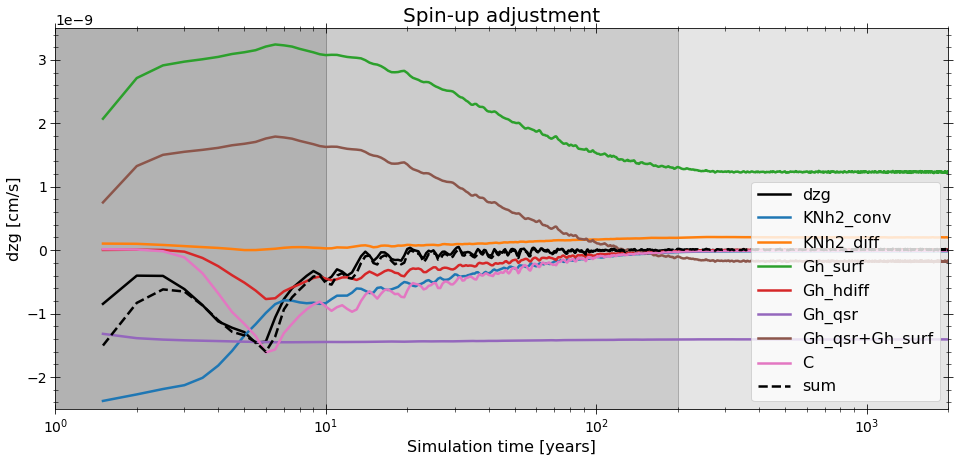

In [16]:
fig, ax = plt.subplots(figsize=(16,7))

x=np.linspace(1,2051,4100)
exp = exp_names[0]
dzg_tot=ds[exp].zgDE.diff('t').rolling({'t':2}).mean('t')/(60*60*24*360/2)

#qns_cdt_roll = Gh_qns_cdt1[exp].rolling({'t':2}).mean('t')
#qsr_roll = 1/(9.81)*qsr_gm[exp].rolling({'t':2}).mean('t')
#Gh=dzg_gm[exp]['qsr']+dzg_gm[exp]['zdf+qns']+dzg_gm[exp]['ldf']+dzg_gm[exp]['cdt']

#plt.plot(x,qns_cdt_roll+qsr_roll,label='qns+cdt+qsr')
#plt.plot(x,qns_cdt_roll+qsr_roll+1/(9.81)*KN2_h_w_avt_inv_gm[exp].rolling({'t':2}).mean('t'),label='qns+cdt+qsr+KN2_diff')
#plt.plot(x,,label='KNh2_conv')
KN2_convective = 1/(9.81)*KN2_h_bot_to_top_convective_gm[exp].rolling({'t':2}).mean('t').compute()
KN2_diffusive = 1/(9.81)*KN2_h_bot_to_top_diffusive_gm[exp].rolling({'t':2}).mean('t').compute()
Gh_surf = 1/(9.81)*(GhT_surfaceflux[exp]+GhS_surfaceflux[exp]).rolling({'t':2}).mean('t').compute()
Gh_hdiff = 1/(9.81)*(GhT_hdiffusion[exp]+GhS_hdiffusion[exp]).rolling({'t':2}).mean('t').compute()
Gh_qsr = 1/(9.81)*(GhT_qsr[exp]).rolling({'t':2}).mean('t').compute()
C=-1/(9.81*1026)*properties[exp].global_mean(ds[exp].ketrd_convP2K,Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t').compute()
plt.plot(x[:-1], dzg_tot, label='dzg',c='k')
plt.plot(x,-KN2_convective,label='KNh2_conv')
plt.plot(x,-KN2_diffusive,label='KNh2_diff')
plt.plot(x,Gh_surf,label='Gh_surf')
plt.plot(x,Gh_hdiff,label='Gh_hdiff')
plt.plot(x,Gh_qsr,label='Gh_qsr')
plt.plot(x,Gh_qsr+Gh_surf,label='Gh_qsr+Gh_surf')
plt.plot(x, C, label='C')
plt.plot(x,- KN2_convective - KN2_diffusive + Gh_surf + +Gh_hdiff + Gh_qsr + C , label='sum', c='k', linestyle='--')

#plt.plot(x,- KN2_convective + Gh_surf + KN2_diffusive - ( + Gh_qsr + Gh_hdiff) - C , label='sum', c='k', linestyle='--')
#plt.plot(x,Gh,label='GH')
#plt.plot(x,Gh-(1/(9.81)*KN2_h_w_avt_gm[exp].rolling({'t':2}).mean('t')),label='GH-Conversion')

plt.fill_between([0,10], -2.5e-9, 3.5e-9, alpha=0.6,color='grey')
plt.fill_between([10,200], -2.5e-9, 3.5e-9,alpha=0.4,color='grey')
plt.fill_between([200,3000], -2.5e-9, 3.5e-9,alpha=0.2,color='grey')

plt.xscale('log')
plt.xlim(1,2e3)
plt.ylim(-2.5e-9, 3.5e-9)
plt.ylabel('dzg [cm/s]',fontsize=16)
plt.xlabel('Simulation time [years]',fontsize=16)
ax.tick_params(top=True, right=True, which='both')
plt.legend(fontsize=16, loc='lower right')
plt.title('Spin-up adjustment',fontsize=20)
#plt.savefig('figures/Fig4_spinup_tendencies_final.png', transparent=True, dpi=300)

Text(0.5, 1.0, 'Spin-up adjustment')

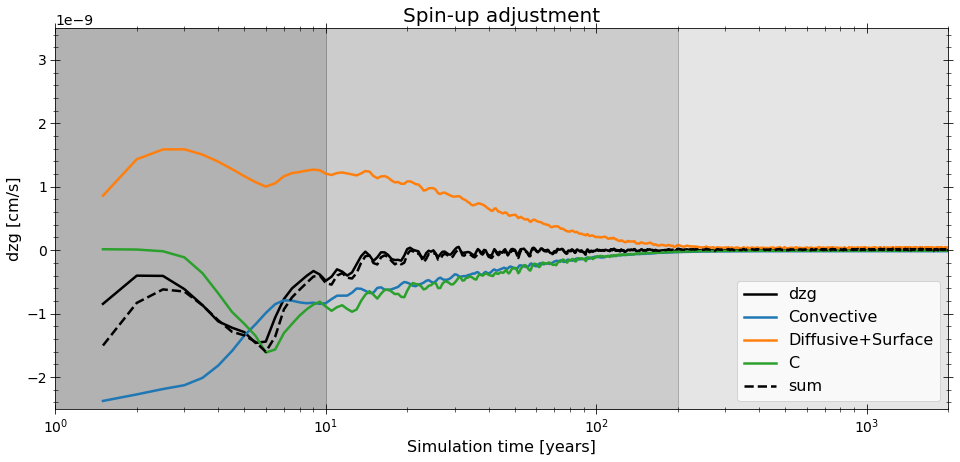

In [67]:
fig, ax = plt.subplots(figsize=(16,7))

x=np.linspace(1,2051,4100)
exp = exp_names[0]
dzg_tot=ds[exp].zgDE.diff('t').rolling({'t':2}).mean('t')/(60*60*24*360/2)

#qns_cdt_roll = Gh_qns_cdt1[exp].rolling({'t':2}).mean('t')
#qsr_roll = 1/(9.81)*qsr_gm[exp].rolling({'t':2}).mean('t')
#Gh=dzg_gm[exp]['qsr']+dzg_gm[exp]['zdf+qns']+dzg_gm[exp]['ldf']+dzg_gm[exp]['cdt']

#plt.plot(x,qns_cdt_roll+qsr_roll,label='qns+cdt+qsr')
#plt.plot(x,qns_cdt_roll+qsr_roll+1/(9.81)*KN2_h_w_avt_inv_gm[exp].rolling({'t':2}).mean('t'),label='qns+cdt+qsr+KN2_diff')
#plt.plot(x,,label='KNh2_conv')
KN2_convective = 1/(9.81)*KN2_h_bot_to_top_convective_gm[exp].rolling({'t':2}).mean('t').compute()
KN2_diffusive = 1/(9.81)*KN2_h_bot_to_top_diffusive_gm[exp].rolling({'t':2}).mean('t').compute()
Gh_surf = 1/(9.81)*(GhT_surfaceflux[exp]+GhS_surfaceflux[exp]).rolling({'t':2}).mean('t').compute()
Gh_hdiff = 1/(9.81)*(GhT_hdiffusion[exp]+GhS_hdiffusion[exp]).rolling({'t':2}).mean('t').compute()
Gh_qsr = 1/(9.81)*(GhT_qsr[exp]).rolling({'t':2}).mean('t').compute()
C=-1/(9.81*1026)*properties[exp].global_mean(ds[exp].ketrd_convP2K,Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t').compute()
plt.plot(x[:-1], dzg_tot, label='dzg',c='k')
plt.plot(x,-KN2_convective,label='Convective')
plt.plot(x,-KN2_diffusive+Gh_qsr+Gh_surf+Gh_hdiff,label='Diffusive+Surface')
# plt.plot(x,Gh_surf,label='Gh_surf')
# plt.plot(x,Gh_hdiff,label='Gh_hdiff')
# plt.plot(x,Gh_qsr,label='Gh_qsr')
plt.plot(x, C, label='C')
plt.plot(x,- KN2_convective - KN2_diffusive + Gh_surf + +Gh_hdiff + Gh_qsr + C , label='sum', c='k', linestyle='--')

#plt.plot(x,- KN2_convective + Gh_surf + KN2_diffusive - ( + Gh_qsr + Gh_hdiff) - C , label='sum', c='k', linestyle='--')
#plt.plot(x,Gh,label='GH')
#plt.plot(x,Gh-(1/(9.81)*KN2_h_w_avt_gm[exp].rolling({'t':2}).mean('t')),label='GH-Conversion')

plt.fill_between([0,10], -2.5e-9, 3.5e-9, alpha=0.6,color='grey')
plt.fill_between([10,200], -2.5e-9, 3.5e-9,alpha=0.4,color='grey')
plt.fill_between([200,3000], -2.5e-9, 3.5e-9,alpha=0.2,color='grey')

plt.xscale('log')
plt.xlim(1,2e3)
plt.ylim(-2.5e-9, 3.5e-9)
plt.ylabel('dzg [cm/s]',fontsize=16)
plt.xlabel('Simulation time [years]',fontsize=16)
ax.tick_params(top=True, right=True, which='both')
plt.legend(fontsize=15,loc='upper right',borderpad=0.3,handlelength=1.5,handletextpad=0.5,labelspacing=0.3,ncol=2,columnspacing=1)
plt.title('Spin-up adjustment',fontsize=20)
#plt.savefig('figures/Fig6_spinup_tendencies_final.png', transparent=True, dpi=300)

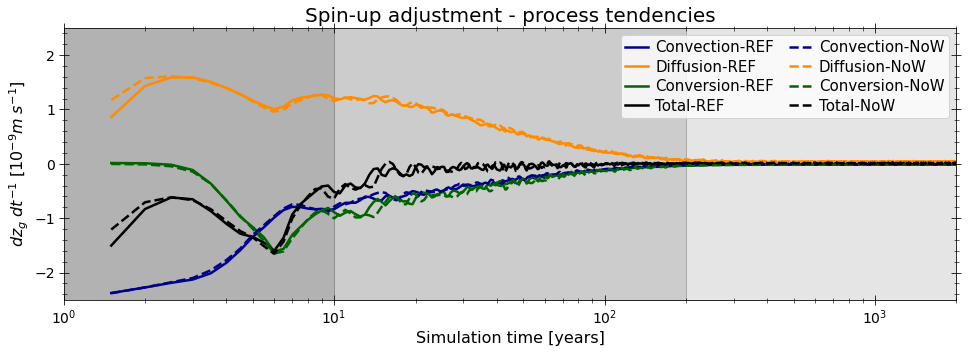

In [16]:
fig, ax = plt.subplots(figsize=(16,5))

x=np.linspace(1,2051,4100)
exp = exp_names[1]
magn=1e9
#dzg_tot=ds[exp].zgDE.diff('t').rolling({'t':2}).mean('t')/(60*60*24*360/2)

#qns_cdt_roll = Gh_qns_cdt1[exp].rolling({'t':2}).mean('t')
#qsr_roll = 1/(9.81)*qsr_gm[exp].rolling({'t':2}).mean('t')
#Gh=dzg_gm[exp]['qsr']+dzg_gm[exp]['zdf+qns']+dzg_gm[exp]['ldf']+dzg_gm[exp]['cdt']

#plt.plot(x,qns_cdt_roll+qsr_roll,label='qns+cdt+qsr')
#plt.plot(x,qns_cdt_roll+qsr_roll+1/(9.81)*KN2_h_w_avt_inv_gm[exp].rolling({'t':2}).mean('t'),label='qns+cdt+qsr+KN2_diff')
#plt.plot(x,,label='KNh2_conv')
exp = exp_names[0]
KN2_convective = 1/(9.81)*KN2_h_bot_to_top_convective_gm[exp].rolling({'t':2}).mean('t').compute()
KN2_diffusive = 1/(9.81)*KN2_h_bot_to_top_diffusive_gm[exp].rolling({'t':2}).mean('t').compute()
Gh_surf = 1/(9.81)*(GhT_surfaceflux[exp]+GhS_surfaceflux[exp]).rolling({'t':2}).mean('t').compute()
Gh_hdiff = 1/(9.81)*(GhT_hdiffusion[exp]+GhS_hdiffusion[exp]).rolling({'t':2}).mean('t').compute()
Gh_qsr = 1/(9.81)*(GhT_qsr[exp]).rolling({'t':2}).mean('t').compute()
C=-1/(9.81*1026)*properties[exp].global_mean(ds[exp].ketrd_convP2K,Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t').compute()
#plt.plot(x[:-1], dzg_tot, label='dzg',c='k')
# plt.plot(x,Gh_surf,label='Gh_surf')
# plt.plot(x,Gh_hdiff,label='Gh_hdiff')
# plt.plot(x,Gh_qsr,label='Gh_qsr')
plt.plot(x,-KN2_convective*magn,label='Convection-REF', c='darkblue')
plt.plot(x,(-KN2_diffusive+Gh_qsr+Gh_surf+Gh_hdiff)*magn,label='Diffusion-REF', c='darkorange')
plt.plot(x, C*magn, label='Conversion-REF', c='darkgreen')
plt.plot(x,(- KN2_convective - KN2_diffusive + Gh_surf + +Gh_hdiff + Gh_qsr + C)*magn , label='Total-REF', c='k')

exp = exp_names[1]
KN2_convective = 1/(9.81)*KN2_h_bot_to_top_convective_gm[exp].rolling({'t':2}).mean('t').compute()
KN2_diffusive = 1/(9.81)*KN2_h_bot_to_top_diffusive_gm[exp].rolling({'t':2}).mean('t').compute()
Gh_surf = 1/(9.81)*(GhT_surfaceflux[exp]+GhS_surfaceflux[exp]).rolling({'t':2}).mean('t').compute()
Gh_hdiff = 1/(9.81)*(GhT_hdiffusion[exp]+GhS_hdiffusion[exp]).rolling({'t':2}).mean('t').compute()
Gh_qsr = 1/(9.81)*(GhT_qsr[exp]).rolling({'t':2}).mean('t').compute()
C=-1/(9.81*1026)*properties[exp].global_mean(ds[exp].ketrd_convP2K,Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t').compute()
#plt.plot(x[:-1], dzg_tot, label='dzg',c='k')
plt.plot(x,(-KN2_convective)*magn,label='Convection-NoW', c='darkblue',linestyle='--')
plt.plot(x,(-KN2_diffusive+Gh_qsr+Gh_surf+Gh_hdiff)*magn,label='Diffusion-NoW', c='darkorange',linestyle='--')
# plt.plot(x,Gh_surf,label='Gh_surf')
# plt.plot(x,Gh_hdiff,label='Gh_hdiff')
# plt.plot(x,Gh_qsr,label='Gh_qsr')
plt.plot(x, C*magn, label='Conversion-NoW', c='darkgreen',linestyle='--')
plt.plot(x,(- KN2_convective - KN2_diffusive + Gh_surf + +Gh_hdiff + Gh_qsr + C)*magn , label='Total-NoW', c='k', linestyle='--')

#plt.plot(x,- KN2_convective + Gh_surf + KN2_diffusive - ( + Gh_qsr + Gh_hdiff) - C , label='sum', c='k', linestyle='--')
#plt.plot(x,Gh,label='GH')
#plt.plot(x,Gh-(1/(9.81)*KN2_h_w_avt_gm[exp].rolling({'t':2}).mean('t')),label='GH-Conversion')

plt.fill_between([0,10], -2.5, 3.5, alpha=0.6,color='grey')
plt.fill_between([10,200], -2.5, 3.5,alpha=0.4,color='grey')
plt.fill_between([200,3000], -2.5, 3.5,alpha=0.2,color='grey')

plt.xscale('log')
plt.xlim(1,2e3)
plt.ylim(-2.5, 2.5)
plt.ylabel('$dz_g\;dt^{-1}$ $[10^{-9} m\;s^{-1}]$',fontsize=16)
plt.xlabel('Simulation time [years]',fontsize=16)
ax.tick_params(top=True, right=True, which='both')
plt.legend(fontsize=15,loc='upper right',borderpad=0.3,handlelength=1.5,handletextpad=0.5,labelspacing=0.3,ncol=2,columnspacing=1)
plt.title('Spin-up adjustment - process tendencies',fontsize=20)
plt.savefig('figures/Fig6_spinup_tendencies_final.png', transparent=True, dpi=300)

NameError: name 'KN2_h_bot_to_top_convective_gm0' is not defined

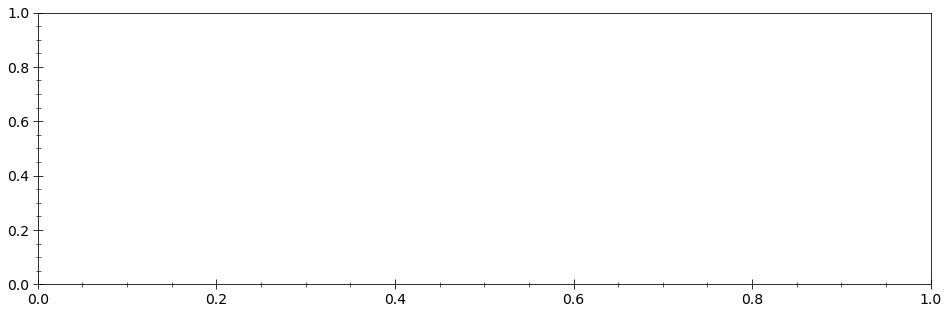

In [14]:
fig, ax = plt.subplots(figsize=(16,5))

x=np.linspace(1,2051,4100)
exp = exp_names[0]
dzg_tot=ds[exp].zgDE_gm.diff('t').rolling({'t':2}).mean('t')/(60*60*24*360/2)

#qns_cdt_roll = Gh_qns_cdt1[exp].rolling({'t':2}).mean('t')
#qsr_roll = 1/(9.81)*qsr_gm[exp].rolling({'t':2}).mean('t')
#Gh=dzg_gm[exp]['qsr']+dzg_gm[exp]['zdf+qns']+dzg_gm[exp]['ldf']+dzg_gm[exp]['cdt']

#plt.plot(x,qns_cdt_roll+qsr_roll,label='qns+cdt+qsr')
#plt.plot(x,qns_cdt_roll+qsr_roll+1/(9.81)*KN2_h_w_avt_inv_gm[exp].rolling({'t':2}).mean('t'),label='qns+cdt+qsr+KN2_diff')
#plt.plot(x,,label='KNh2_conv')
KN2_convective = 1/(9.81)*(KN2_h_bot_to_top_convective_gm[exp]-KN2_h_bot_to_top_convective_gm0[exp]).rolling({'t':2}).mean('t').compute()
KN2_diffusive = 1/(9.81)*(KN2_h_bot_to_top_diffusive_gm[exp]-KN2_h_bot_to_top_diffusive_gm0[exp]).rolling({'t':2}).mean('t').compute()
Gh_surf = 1/(9.81)*((GhT_surfaceflux[exp]+GhS_surfaceflux[exp])-(GhT_surfaceflux0[exp]+GhS_surfaceflux0[exp])).rolling({'t':2}).mean('t').compute()
Gh_hdiff = 1/(9.81)*((GhT_hdiffusion[exp]+GhS_hdiffusion[exp])-(GhT_hdiffusion0[exp]+GhS_hdiffusion0[exp])).rolling({'t':2}).mean('t').compute()
Gh_qsr = 1/(9.81)*(GhT_qsr[exp]-GhT_qsr0[exp]).rolling({'t':2}).mean('t').compute()
C=-1/(9.81*1026)*properties[exp].global_mean(ds[exp].ketrd_convP2K,Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t').compute()
plt.plot(x[:-1], dzg_tot, label='dzg',c='k')
plt.plot(x,-KN2_convective,label='KNh2_conv')
plt.plot(x,-KN2_diffusive,label='KNh2_diff')
plt.plot(x,Gh_surf,label='Gh_surf')
plt.plot(x,Gh_hdiff,label='Gh_hdiff')
plt.plot(x,Gh_qsr,label='Gh_qsr')
plt.plot(x,Gh_qsr+Gh_surf,label='Gh_qsr+Gh_surf')
plt.plot(x, C, label='C')
plt.plot(x,- KN2_convective - KN2_diffusive + Gh_surf + +Gh_hdiff + Gh_qsr + C , label='sum', c='k', linestyle='--')

#plt.plot(x,- KN2_convective + Gh_surf + KN2_diffusive - ( + Gh_qsr + Gh_hdiff) - C , label='sum', c='k', linestyle='--')
#plt.plot(x,Gh,label='GH')
#plt.plot(x,Gh-(1/(9.81)*KN2_h_w_avt_gm[exp].rolling({'t':2}).mean('t')),label='GH-Conversion')

plt.fill_between([0,10], -2.5e-9, 3.5e-9, alpha=0.6,color='grey')
plt.fill_between([10,200], -2.5e-9, 3.5e-9,alpha=0.4,color='grey')
plt.fill_between([200,3000], -2.5e-9, 3.5e-9,alpha=0.2,color='grey')

plt.xscale('log')
plt.xlim(1,2e3)
plt.ylim(-2.5e-9, 3.5e-9)
plt.ylabel('dzg [cm/s]',fontsize=16)
plt.xlabel('Simulation time [years]',fontsize=16)
ax.tick_params(top=True, right=True, which='both')
plt.legend(fontsize=16, loc='lower right')
plt.title('Spin-up adjustment',fontsize=20)
#plt.savefig('figures/Fig4_spinup_tendencies_final.png', transparent=True, dpi=300)

/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in ar

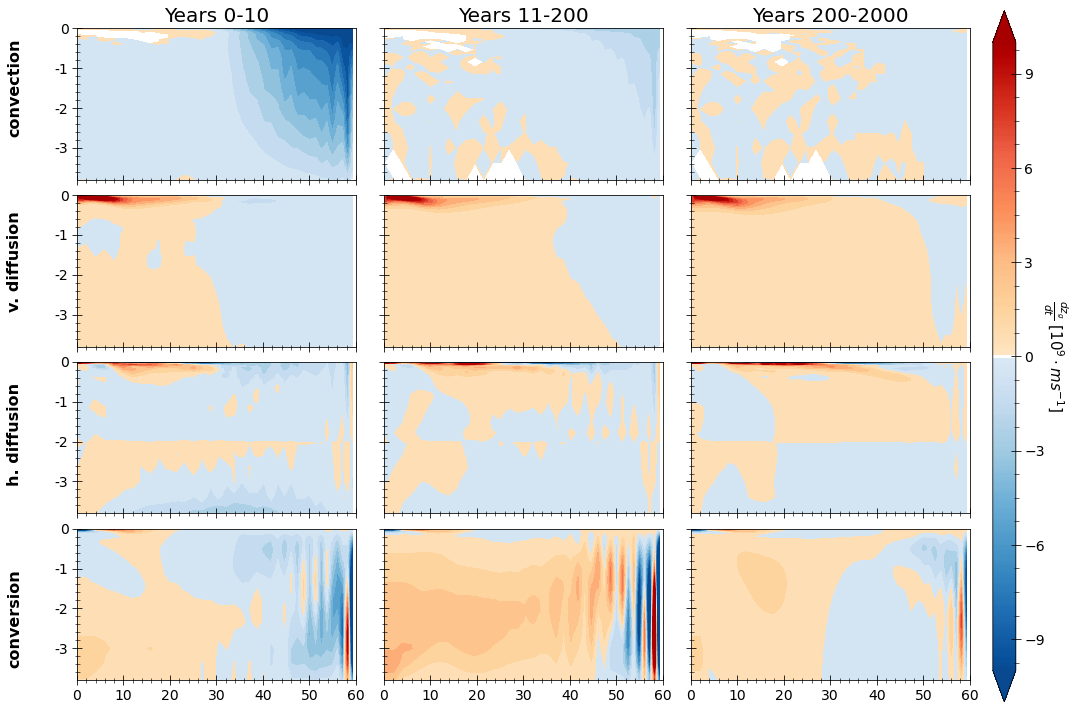

In [46]:
from matplotlib.cm import ScalarMappable

exp = exp_names[0]
phi = ds[exp].gphit[:,0]
lam = ds[exp].glamt[0,:]
depth = properties[exp].coords['Z']
YZ,ZY = np.meshgrid(phi.values,depth.values[:-1])
XY,YX = np.meshgrid(lam.values,phi.values)

fig,ax=plt.subplots(4,3,figsize=(16,12))
KN2_convective = grid_ops[exp].average( 1/(9.81)*KN2_h_bot_to_top_convective[exp].rolling({'t':2}).mean('t')*1e9,'X').compute()  
KN2_diffusive = grid_ops[exp].average( 1/(9.81)*KN2_h_bot_to_top_diffusive[exp].rolling({'t':2}).mean('t')*1e9,'X').compute()
Gh_hdiff = grid_ops[exp].average( 1/(9.81)*(GhT_hdiffusion_gm[exp]+GhS_hdiffusion_gm[exp]).rolling({'t':2}).mean('t')*1e9,'X').compute()
Gh_qsr = grid_ops[exp].average( 1/(9.81)*(GhT_qsr3d[exp]).rolling({'t':2}).mean('t')*1e9,'X').compute()
C= grid_ops[exp].average(1/(9.81*1026)*(ds[exp].ketrd_convP2K).rolling({'t':2}).mean('t').rolling({'y_c':2}).mean('y_c')*1e9,'X').compute()

for i, time in enumerate([slice(0,21), slice(21,401), slice(401,-1)]):#, slice(-21,-1)]):
    # Gh_surf = 1/(9.81)*(GhT_surfaceflux[exp]+GhS_surfaceflux[exp]).rolling({'t':2}).mean('t').compute()
    
    cticks=np.linspace(-10,10,21)
    c1=ax[0,i].contourf(YZ,ZY,(-KN2_convective[time]).mean('t')[:-1],cmap=cmap_OB,extend='both',levels=cticks)
    c2=ax[1,i].contourf(YZ,ZY,(-KN2_diffusive[time]).mean('t')[:-1],cmap=cmap_OB,extend='both',levels=cticks)
    c3=ax[2,i].contourf(YZ,ZY,(Gh_hdiff[time]).mean('t')[:-1],cmap=cmap_OB,extend='both',levels=cticks)
    c4=ax[3,i].contourf(YZ,ZY,(-C[time]).mean('t')[:-1],cmap=cmap_OB,extend='both',levels=cticks)
    for j in range(4):
        ax[j,i].set_yticks([-4000,-3000,-2000,-1000,0])
        ax[j,i].set_xlim(0,60)
        ax[j,i].set_ylim(-3800,0)
        if i>0: 
            ax[j,i].set_yticklabels([])
        else:
            ax[j,i].set_yticklabels([0,-1,-2,-3,-4][::-1])
        if j<3:
            ax[j,i].set_xticklabels([])
    # plt.colorbar(c1,ax=ax[i,0])
    # plt.colorbar(c2,ax=ax[i,1])
    # plt.colorbar(c3,ax=ax[i,2])
    # plt.colorbar(c3,ax=ax[i,3])
ax_cb=fig.add_axes([0.92, 0.1, 0.02, 0.8])
cbar=plt.colorbar(ScalarMappable(norm=c1.norm, cmap=c1.cmap),ax=ax_cb,cax=ax_cb,
             ticks=np.arange(-9, 10, 3),
             extend='both', pad=0.02)
cbar.set_label(r'$\frac{dz_g}{dt}$ [$10^9\cdot m s^{-1}$]',rotation=-90,labelpad=25,fontsize=15)
ax[0,0].set_title("Years 0-10")
ax[0,1].set_title("Years 11-200")
ax[0,2].set_title("Years 200-2000")


ax[0,0].annotate('convection',[-0.25,0.3],xycoords='axes fraction',
                 fontweight='bold',fontsize=16,rotation=90)
ax[1,0].annotate('v. diffusion',[-0.25,0.25],
                 fontweight='bold',xycoords='axes fraction',fontsize=16,rotation=90)

ax[2,0].annotate('h. diffusion',[-0.25,0.2],xycoords='axes fraction',
                 fontweight='bold',fontsize=16,rotation=90)
ax[3,0].annotate('conversion',[-0.25,0.1],
                 fontweight='bold',xycoords='axes fraction',fontsize=16,rotation=90)

plt.subplots_adjust(hspace=0.1, wspace=0.1)
#plt.savefig('figures/Fig5_spinup_tendencies_contours.png', transparent=True, dpi=300)
#ax[0,3].set_title("Penetrative Heating (1e-10)")
    #plt.contour(YZ,ZY,cont_C[:-1],extend='both',levels=[-10,0,10],colors='k',alpha=.5,linewidths=1)
    #plt.contour(YZ,ZY,cont_D[:-1],extend='both',levels=[-10,0,10],colors='g',alpha=.5,linewidths=1)

In [16]:
Gh_hdiff_exp0 = xr.DataArray(grid_ops[exp0].average( 1e9/(9.81)*(GhT_hdiffusion_gm[exp0]+GhS_hdiffusion_gm[exp0]).rolling({'t':2}).mean('t'),['X','Y'],Vmask=ds[exp0].mask_bd_t).values, coords=KN2_diffusive_exp0.coords)


/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


ValueError: different number of dimensions on data and dims: 2 vs 3

In [ ]:
exp0=exp_names[0]
exp1=exp_names[1]
KN2_convective_exp0 = grid_ops[exp0].average( 1e9/(9.81)*KN2_h_bot_to_top_convective[exp0].rolling({'t':2}).mean('t'),['X','Y'],Vmask=ds[exp0].mask_bd_w).compute()  
KN2_diffusive_exp0 = grid_ops[exp0].average( 1e9/(9.81)*KN2_h_bot_to_top_diffusive[exp0].rolling({'t':2}).mean('t'),['X','Y'],Vmask=ds[exp0].mask_bd_w).compute()
#C_exp0= grid_ops[exp0].average(1/(9.81*1026)*(ds[exp0].ketrd_convP2K).rolling({'t':2}).mean('t').rolling({'y_c':2}).mean('y_c')*1e9,['X','Y']).compute() 
C_exp0= grid_ops[exp0].average(1e9/(9.81*1026)*(ds[exp0].ketrd_convP2K).rolling({'t':2}).mean('t'),['X','Y'],Vmask=ds[exp0].mask_bd_t).compute() 
Gh_hdiff_exp0 = xr.DataArray(grid_ops[exp0].average( 1e9/(9.81)*(GhT_hdiffusion_gm[exp0]+GhS_hdiffusion_gm[exp0]).rolling({'t':2}).mean('t'),['X','Y'],Vmask=ds[exp0].mask_bd_t).values, coords=KN2_convective_exp0.coords)
Gh_qsr_exp0 = xr.DataArray(grid_ops[exp0].average( 1e9/(9.81)*(GhT_qsr3d[exp0]).rolling({'t':2}).mean('t'),['X','Y'],Vmask=ds[exp0].mask_bd_t).values, coords=KN2_convective_exp0.coords).fillna(0)

KN2_convective_exp1 = grid_ops[exp1].average( 1e9/(9.81)*KN2_h_bot_to_top_convective[exp1].rolling({'t':2}).mean('t'),['X','Y'],Vmask=ds[exp1].mask_bd_w).compute()  
KN2_diffusive_exp1 = grid_ops[exp1].average( 1e9/(9.81)*KN2_h_bot_to_top_diffusive[exp1].rolling({'t':2}).mean('t'),['X','Y'],Vmask=ds[exp1].mask_bd_w).compute()
#C_exp1 = grid_ops[exp1].average(1e9/(9.81*1026)*(ds[exp1].ketrd_convP2K).rolling({'t':2}).mean('t').rolling({'y_c':2}).mean('y_c'),['X','Y']).compute()
C_exp1 = grid_ops[exp1].average(1e9/(9.81*1026)*(ds[exp1].ketrd_convP2K).rolling({'t':2}).mean('t'),['X','Y'],Vmask=ds[exp1].mask_bd_t).compute() 
Gh_hdiff_exp1= xr.DataArray(grid_ops[exp1].average( 1e9/(9.81)*(GhT_hdiffusion_gm[exp1]+GhS_hdiffusion_gm[exp1]).rolling({'t':2}).mean('t'),['X','Y'],Vmask=ds[exp1].mask_bd_t).values, coords=KN2_convective_exp1.coords)
Gh_qsr_exp1 = xr.DataArray(grid_ops[exp1].average( 1e9/(9.81)*(GhT_qsr3d[exp1]).rolling({'t':2}).mean('t'),['X','Y'],Vmask=ds[exp1].mask_bd_t).values, coords=KN2_convective_exp1.coords).fillna(0)


/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in ar

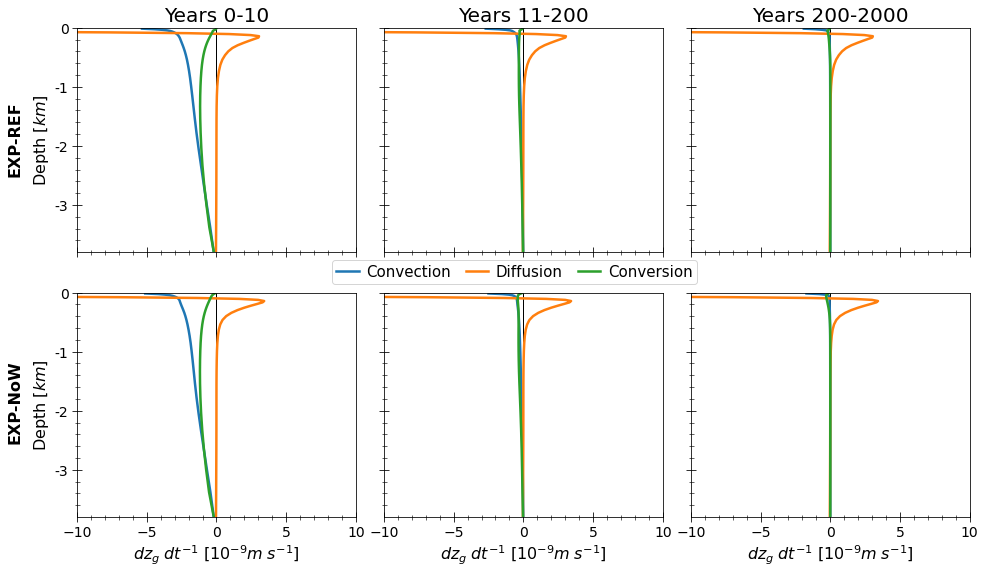

In [ ]:
from matplotlib.cm import ScalarMappable

exp = exp_names[0]
phi = ds[exp].gphit[:,0]
lam = ds[exp].glamt[0,:]
depth = properties[exp].coords['Z']
YZ,ZY = np.meshgrid(phi.values,depth.values[:-1])
XY,YX = np.meshgrid(lam.values,phi.values)

fig,ax=plt.subplots(2,3,figsize=(16,9))
# Gh_surf = 1/(9.81)*(GhT_surfaceflux[exp]+GhS_surfaceflux[exp]).rolling({'t':2}).mean('t').compute()



for i, time in enumerate([slice(0,21), slice(21,401), slice(401,-1)]):
    for j, exp in enumerate(exp_names):
        ax[j,i].set_yticks([-4000,-3000,-2000,-1000,0])
        ax[j,i].set_xlim(-10,10)
        ax[j,i].set_ylim(-3800,0)
        if i>0: 
            ax[j,i].set_yticklabels([])
        else:
            ax[j,i].set_yticklabels([0,-1,-2,-3,-4][::-1])
        if j<1:
            ax[j,i].set_xticklabels([])
        ax[j,i].vlines(0, -4000, 0, color='k',linestyle='-', linewidth=1)
    ax[0,i].plot((-KN2_convective_exp0[time]).mean('t')[:-1],ds[exp0].depth_1d[:-1], label='Convection')
    ax[0,i].plot((-KN2_diffusive_exp0+Gh_qsr_exp0+Gh_hdiff_exp0).mean('t')[:-1],ds[exp0].depth_1d[:-1], label='Diffusion')
    ax[0,i].plot((-C_exp0[time]).mean('t')[:-1],ds[exp0].depth_1d[:-1], label='Conversion')
    ax[1,i].plot((-KN2_convective_exp1[time]).mean('t')[:-1],ds[exp1].depth_1d[:-1])
    ax[1,i].plot((-KN2_diffusive_exp1+Gh_qsr_exp1+Gh_hdiff_exp1).mean('t')[:-1],ds[exp1].depth_1d[:-1])
    ax[1,i].plot((-C_exp1[time]).mean('t')[:-1],ds[exp1].depth_1d[:-1])
    ax[1,i].set_xlabel('$dz_g\;dt^{-1}$ $[10^{-9} m\;s^{-1}]$',fontsize=16)

ax[0,0].set_ylabel('Depth $[km]$',fontsize=16)
ax[1,0].set_ylabel('Depth $[km]$',fontsize=16)

ax[0,0].set_title("Years 0-10")
ax[0,1].set_title("Years 11-200")
ax[0,2].set_title("Years 200-2000")

ax[0,0].annotate('EXP-REF',[-0.25,0.35],xycoords='axes fraction',
                 fontweight='bold',fontsize=16,rotation=90)
ax[1,0].annotate('EXP-NoW',[-0.25,0.34],
                 fontweight='bold',xycoords='axes fraction',fontsize=16,rotation=90)

plt.subplots_adjust(hspace=0.18, wspace=0.1)
plt.savefig('figures/Fig6_spinup_profiles.png', transparent=True, dpi=300)
ax[0,0].legend(fontsize=15, bbox_to_anchor=(2.25,0.0) , borderpad=0.3,handlelength=1.5,handletextpad=0.5,labelspacing=0.3,ncol=3,columnspacing=1)
#ax[0,3].set_title("Penetrative Heating (1e-10)")
    #plt.contour(YZ,ZY,cont_C[:-1],extend='both',levels=[-10,0,10],colors='k',alpha=.5,linewidths=1)
    #plt.contour(YZ,ZY,cont_D[:-1],extend='both',levels=[-10,0,10],colors='g',alpha=.5,linewidths=1)

In [ ]:
from matplotlib.cm import ScalarMappable

exp = exp_names[0]
phi = ds[exp].gphit[:,0]
lam = ds[exp].glamt[0,:]
depth = properties[exp].coords['Z']
YZ,ZY = np.meshgrid(phi.values,depth.values[:-1])
XY,YX = np.meshgrid(lam.values,phi.values)

fig,ax=plt.subplots(4,3,figsize=(16,12))
KN2_convective = grid_ops[exp].average( 1/(9.81)*KN2_h_bot_to_top_convective[exp].rolling({'t':2}).mean('t')*1e9,'X').compute()  
KN2_diffusive = grid_ops[exp].average( 1/(9.81)*KN2_h_bot_to_top_diffusive[exp].rolling({'t':2}).mean('t')*1e9,'X').compute()
Gh_hdiff = grid_ops[exp].average( 1/(9.81)*(GhT_hdiffusion_gm[exp]+GhS_hdiffusion_gm[exp]).rolling({'t':2}).mean('t')*1e9,'X').compute()
Gh_qsr = grid_ops[exp].average( 1/(9.81)*(GhT_qsr3d[exp]).rolling({'t':2}).mean('t')*1e9,'X').compute()

for i, time in enumerate([slice(0,21), slice(21,401), slice(401,-1)]):#, slice(-21,-1)]):
    # Gh_surf = 1/(9.81)*(GhT_surfaceflux[exp]+GhS_surfaceflux[exp]).rolling({'t':2}).mean('t').compute()
    
    cticks=np.linspace(-10,10,21)
    c1=ax[0,i].contourf(YZ,ZY,(-KN2_convective[time]).mean('t')[:-1],cmap=cmap_OB,extend='both',levels=cticks)
    c2=ax[1,i].contourf(YZ,ZY,(-KN2_diffusive[time]).mean('t')[:-1],cmap=cmap_OB,extend='both',levels=cticks)
    c3=ax[2,i].contourf(YZ,ZY,(Gh_hdiff[time]).mean('t')[:-1],cmap=cmap_OB,extend='both',levels=cticks)
    c4=ax[3,i].contourf(YZ,ZY,(Gh_qsr[time]).mean('t')[:-1],cmap=cmap_OB,extend='both',levels=cticks)
    for j in range(4):
        ax[j,i].set_yticks([-4000,-3000,-2000,-1000,0])
        ax[j,i].set_xlim(0,60)
        ax[j,i].set_ylim(-3800,0)
        if i>0: 
            ax[j,i].set_yticklabels([])
        else:
            ax[j,i].set_yticklabels([0,-1,-2,-3,-4][::-1])
        if j<3:
            ax[j,i].set_xticklabels([])
    # plt.colorbar(c1,ax=ax[i,0])
    # plt.colorbar(c2,ax=ax[i,1])
    # plt.colorbar(c3,ax=ax[i,2])
    # plt.colorbar(c3,ax=ax[i,3])
ax_cb=fig.add_axes([0.92, 0.1, 0.02, 0.8])
cbar=plt.colorbar(ScalarMappable(norm=c1.norm, cmap=c1.cmap),ax=ax_cb,cax=ax_cb,
             ticks=np.arange(-9, 10, 3),
             extend='both', pad=0.02)
cbar.set_label(r'$\frac{dz_g}{dt}$ [$10^9\cdot m s^{-1}$]',rotation=-90,labelpad=25,fontsize=15)
ax[0,0].set_title("Years 0-10")
ax[0,1].set_title("Years 11-200")
ax[0,2].set_title("Years 200-2000")


ax[0,0].annotate('convection',[-0.25,0.3],xycoords='axes fraction',
                 fontweight='bold',fontsize=16,rotation=90)
ax[1,0].annotate('v. diffusion',[-0.25,0.25],
                 fontweight='bold',xycoords='axes fraction',fontsize=16,rotation=90)

ax[2,0].annotate('h. diffusion',[-0.25,0.2],xycoords='axes fraction',
                 fontweight='bold',fontsize=16,rotation=90)
ax[3,0].annotate('pen. heating',[-0.25,0.1],
                 fontweight='bold',xycoords='axes fraction',fontsize=16,rotation=90)

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.savefig('figures/Fig5_spinup_tendencies_contours.png', transparent=True, dpi=300)
#ax[0,3].set_title("Penetrative Heating (1e-10)")
    #plt.contour(YZ,ZY,cont_C[:-1],extend='both',levels=[-10,0,10],colors='k',alpha=.5,linewidths=1)
    #plt.contour(YZ,ZY,cont_D[:-1],extend='both',levels=[-10,0,10],colors='g',alpha=.5,linewidths=1)

/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


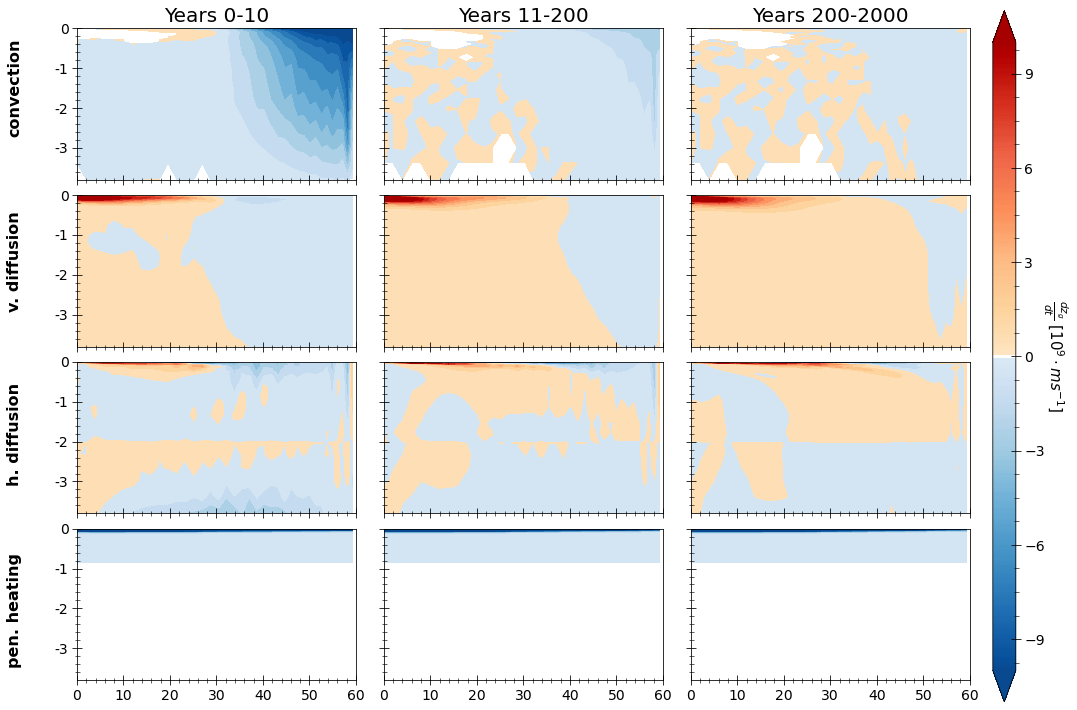

In [23]:
from matplotlib.cm import ScalarMappable

exp = exp_names[1]
phi = ds[exp].gphit[:,0]
lam = ds[exp].glamt[0,:]
depth = properties[exp].coords['Z']
YZ,ZY = np.meshgrid(phi.values,depth.values[:-1])
XY,YX = np.meshgrid(lam.values,phi.values)

fig,ax=plt.subplots(4,3,figsize=(16,12))
KN2_convective = grid_ops[exp].average( 1/(9.81)*KN2_h_bot_to_top_convective[exp].rolling({'t':2}).mean('t')*1e9,'X').compute()  
KN2_diffusive = grid_ops[exp].average( 1/(9.81)*KN2_h_bot_to_top_diffusive[exp].rolling({'t':2}).mean('t')*1e9,'X').compute()
Gh_hdiff = grid_ops[exp].average( 1/(9.81)*(GhT_hdiffusion_gm[exp]+GhS_hdiffusion_gm[exp]).rolling({'t':2}).mean('t')*1e9,'X').compute()
Gh_qsr = grid_ops[exp].average( 1/(9.81)*(GhT_qsr3d[exp]).rolling({'t':2}).mean('t')*1e9,'X').compute()

for i, time in enumerate([slice(0,21), slice(21,401), slice(401,-1)]):#, slice(-21,-1)]):
    # Gh_surf = 1/(9.81)*(GhT_surfaceflux[exp]+GhS_surfaceflux[exp]).rolling({'t':2}).mean('t').compute()
    
    cticks=np.linspace(-10,10,21)
    c1=ax[0,i].contourf(YZ,ZY,(-KN2_convective[time]).mean('t')[:-1],cmap=cmap_OB,extend='both',levels=cticks)
    c2=ax[1,i].contourf(YZ,ZY,(-KN2_diffusive[time]).mean('t')[:-1],cmap=cmap_OB,extend='both',levels=cticks)
    c3=ax[2,i].contourf(YZ,ZY,(Gh_hdiff[time]).mean('t')[:-1],cmap=cmap_OB,extend='both',levels=cticks)
    c4=ax[3,i].contourf(YZ,ZY,(Gh_qsr[time]).mean('t')[:-1],cmap=cmap_OB,extend='both',levels=cticks)
    for j in range(4):
        ax[j,i].set_yticks([-4000,-3000,-2000,-1000,0])
        ax[j,i].set_xlim(0,60)
        ax[j,i].set_ylim(-3800,0)
        if i>0: 
            ax[j,i].set_yticklabels([])
        else:
            ax[j,i].set_yticklabels([0,-1,-2,-3,-4][::-1])
        if j<3:
            ax[j,i].set_xticklabels([])
    # plt.colorbar(c1,ax=ax[i,0])
    # plt.colorbar(c2,ax=ax[i,1])
    # plt.colorbar(c3,ax=ax[i,2])
    # plt.colorbar(c3,ax=ax[i,3])
ax_cb=fig.add_axes([0.92, 0.1, 0.02, 0.8])
cbar=plt.colorbar(ScalarMappable(norm=c1.norm, cmap=c1.cmap),ax=ax_cb,cax=ax_cb,
             ticks=np.arange(-9, 10, 3),
             extend='both', pad=0.02)
cbar.set_label(r'$\frac{dz_g}{dt}$ [$10^9\cdot m s^{-1}$]',rotation=-90,labelpad=25,fontsize=15)
ax[0,0].set_title("Years 0-10")
ax[0,1].set_title("Years 11-200")
ax[0,2].set_title("Years 200-2000")


ax[0,0].annotate('convection',[-0.25,0.3],xycoords='axes fraction',
                 fontweight='bold',fontsize=16,rotation=90)
ax[1,0].annotate('v. diffusion',[-0.25,0.25],
                 fontweight='bold',xycoords='axes fraction',fontsize=16,rotation=90)

ax[2,0].annotate('h. diffusion',[-0.25,0.2],xycoords='axes fraction',
                 fontweight='bold',fontsize=16,rotation=90)
ax[3,0].annotate('pen. heating',[-0.25,0.1],
                 fontweight='bold',xycoords='axes fraction',fontsize=16,rotation=90)

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.savefig('figures/Fig5_spinup_tendencies_contours_nowind.png', transparent=True, dpi=300)
#ax[0,3].set_title("Penetrative Heating (1e-10)")
    #plt.contour(YZ,ZY,cont_C[:-1],extend='both',levels=[-10,0,10],colors='k',alpha=.5,linewidths=1)
    #plt.contour(YZ,ZY,cont_D[:-1],extend='both',levels=[-10,0,10],colors='g',alpha=.5,linewidths=1)

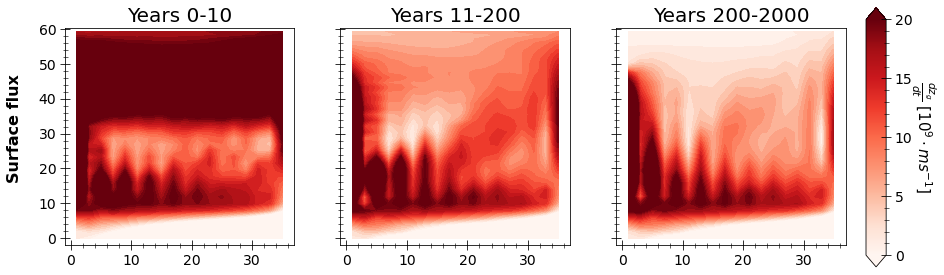

In [35]:
fig,ax=plt.subplots(1,3,figsize=(14,4))
exp = exp_names[0]
for i, time in enumerate([slice(0,21), slice(21,401), slice(401,-1)]):
    Gh_surf = 1/(9.81)*(GhT_surfaceflux2d[exp]+GhS_surfaceflux2d[exp]).rolling({'t':2}).mean('t')[time].mean('t').compute()
    cticks=np.linspace(0,20,21)
    c1=ax[i].contourf(XY,YX,Gh_surf*1e9,cmap='Reds',extend='both',levels=cticks)

ax_cb=fig.add_axes([0.92, 0.05, 0.02, 0.9])
cbar=plt.colorbar(ScalarMappable(norm=c1.norm, cmap=c1.cmap),ax=ax_cb,cax=ax_cb,
             ticks=np.arange(0, 21, 5),
             extend='both', pad=0.02)

cbar.set_label(r'$\frac{dz_g}{dt}$ [$10^9\cdot m s^{-1}$]',rotation=-90,labelpad=25,fontsize=15)
ax[0].set_title("Years 0-10")
ax[1].set_title("Years 11-200")
ax[2].set_title("Years 200-2000")
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])

ax[0].annotate('Surface flux',[-0.25,0.3],xycoords='axes fraction',
                 fontweight='bold',fontsize=16,rotation=90)
plt.savefig('figures/Fig5_spinup_surfaceflux_contours.png', transparent=True, dpi=300)

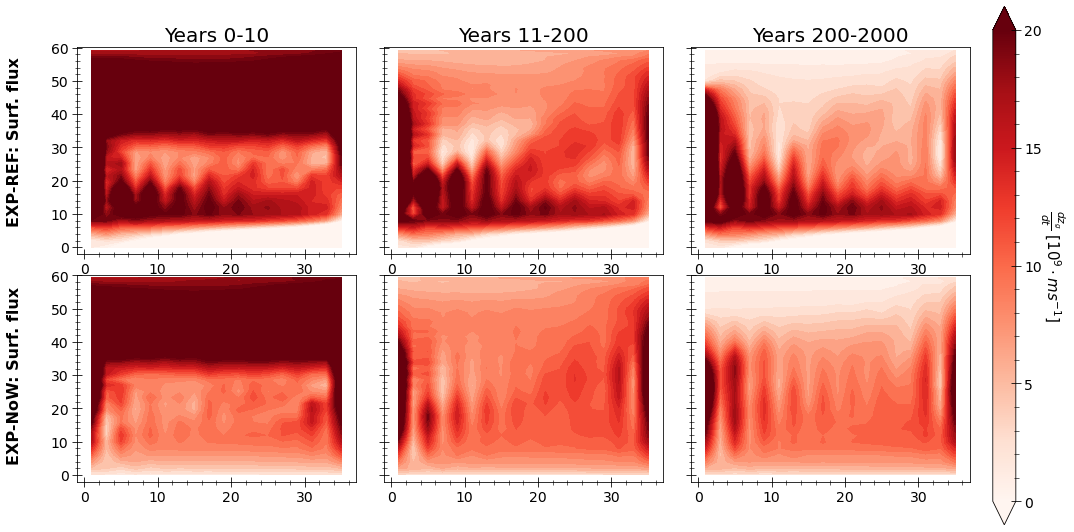

In [39]:
fig,ax=plt.subplots(2,3,figsize=(16,8))
exp = exp_names[1]
for j, exp in enumerate(ds):
    for i, time in enumerate([slice(0,21), slice(21,401), slice(401,-1)]):
        Gh_surf = 1/(9.81)*(GhT_surfaceflux2d[exp]+GhS_surfaceflux2d[exp]).rolling({'t':2}).mean('t')[time].mean('t').compute()
        cticks=np.linspace(0,20,21)
        c1=ax[j,i].contourf(XY,YX,Gh_surf*1e9,cmap='Reds',extend='both',levels=cticks)

        ax[j,1].set_yticklabels([])
        ax[j,2].set_yticklabels([])

ax[0,0].annotate('EXP-REF: Surf. flux',[-0.25,0.15],xycoords='axes fraction',
                fontweight='bold',fontsize=16,rotation=90)

ax[1,0].annotate('EXP-NoW: Surf. flux',[-0.25,0.1],xycoords='axes fraction',
                fontweight='bold',fontsize=16,rotation=90)

ax[0,0].set_title("Years 0-10")
ax[0,1].set_title("Years 11-200")
ax[0,2].set_title("Years 200-2000")

ax_cb=fig.add_axes([0.92, 0.05, 0.02, 0.9])
cbar=plt.colorbar(ScalarMappable(norm=c1.norm, cmap=c1.cmap),ax=ax_cb,cax=ax_cb,
            ticks=np.arange(0, 21, 5),
            extend='both', pad=0.02)

plt.subplots_adjust(hspace=0.1, wspace=0.1)
cbar.set_label(r'$\frac{dz_g}{dt}$ [$10^9\cdot m s^{-1}$]',rotation=-90,labelpad=25,fontsize=15)
plt.savefig('figures/Fig5_spinup_surfaceflux_contours_both.png', transparent=True, dpi=300)

Text(0.5, 1.0, 'Spin-up adjustment')

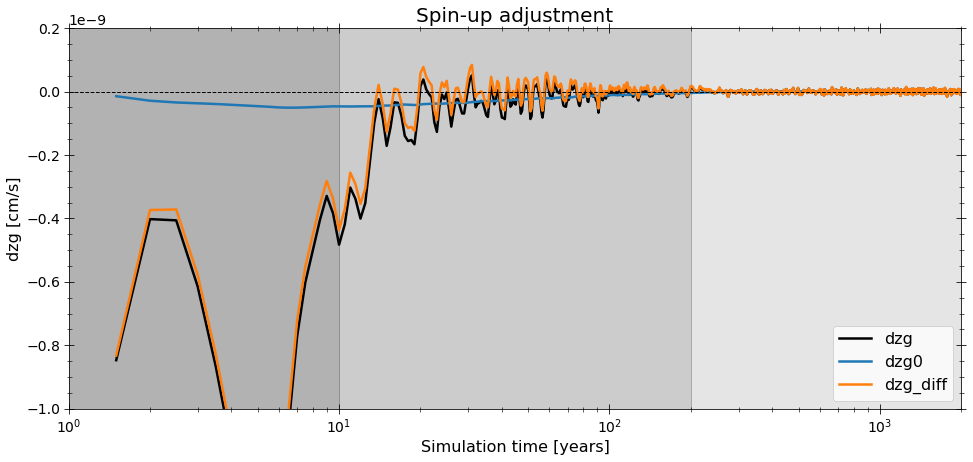

In [43]:
fig, ax = plt.subplots(figsize=(16,7))

x=np.linspace(1,2051,4100)
exp = exp_names[0]
dzg_tot=ds[exp].zgDE.diff('t').rolling({'t':2}).mean('t')/(60*60*24*360/2)
dzg_tot0=ds[exp].zgDE_gm.diff('t').rolling({'t':2}).mean('t')/(60*60*24*360/2)
dzg_totdiff=(ds[exp].zgDE-ds[exp].zgDE_gm).diff('t').rolling({'t':2}).mean('t')/(60*60*24*360/2)

# KN2_convective = 1/(9.81)*(KN2_h_bot_to_top_convective_gm[exp]-KN2_h_bot_to_top_convective_gm0[exp]).rolling({'t':2}).mean('t').compute()
# KN2_diffusive = 1/(9.81)*(KN2_h_bot_to_top_diffusive_gm[exp]-KN2_h_bot_to_top_diffusive_gm0[exp]).rolling({'t':2}).mean('t').compute()
# Gh_surf = 1/(9.81)*((GhT_surfaceflux[exp]+GhS_surfaceflux[exp])-(GhT_surfaceflux0[exp]+GhS_surfaceflux0[exp])).rolling({'t':2}).mean('t').compute()
# Gh_hdiff = 1/(9.81)*((GhT_hdiffusion[exp]+GhS_hdiffusion[exp])-(GhT_hdiffusion0[exp]+GhS_hdiffusion0[exp])).rolling({'t':2}).mean('t').compute()
# Gh_qsr = 1/(9.81)*(GhT_qsr[exp]-GhT_qsr0[exp]).rolling({'t':2}).mean('t').compute()
# C=-1/(9.81*1026)*properties[exp].global_mean(ds[exp].ketrd_convP2K,Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t').compute()
# plt.plot(x[:-1], dzg_tot, label='dzg',c='k')
# plt.plot(x,-KN2_convective,label='KNh2_conv')
# plt.plot(x,-KN2_diffusive,label='KNh2_diff')
# plt.plot(x,Gh_surf,label='Gh_surf')
# plt.plot(x,Gh_hdiff,label='Gh_hdiff')
# plt.plot(x,Gh_qsr,label='Gh_qsr')
# plt.plot(x,Gh_qsr+Gh_surf,label='Gh_qsr+Gh_surf')
# plt.plot(x, C, label='C')
# plt.plot(x,- KN2_convective - KN2_diffusive + Gh_surf + +Gh_hdiff + Gh_qsr + C , label='sum', c='k', linestyle='--')

plt.plot(x[:-1], dzg_tot, label='dzg',c='k')
plt.plot(x[:-1], dzg_tot0, label='dzg0')
plt.plot(x[:-1], dzg_totdiff, label='dzg_diff')
plt.hlines(0,1,2000,linestyle='--',color='k',linewidth=1)

plt.fill_between([0,10], -2.5e-9, 3.5e-9, alpha=0.6,color='grey')
plt.fill_between([10,200], -2.5e-9, 3.5e-9,alpha=0.4,color='grey')
plt.fill_between([200,3000], -2.5e-9, 3.5e-9,alpha=0.2,color='grey')

plt.xscale('log')
plt.xlim(1,2e3)
plt.ylim(-1e-9, .2e-9)
plt.ylabel('dzg [cm/s]',fontsize=16)
plt.xlabel('Simulation time [years]',fontsize=16)
ax.tick_params(top=True, right=True, which='both')
plt.legend(fontsize=16, loc='lower right')
plt.title('Spin-up adjustment',fontsize=20)
#plt.savefig('figures/Fig4_spinup_tendencies_final.png', transparent=True, dpi=300)

In [76]:
KN2_mask_positive = {exp: grid_ops[exp].sign_mask(KN2_h_w[exp]) for exp in exp_conv}
KN2_mask_negative = {exp: grid_ops[exp].sign_mask(KN2_h_w[exp], invert=True) for exp in exp_conv}


In [77]:
KN2_positive_gm = {exp: properties[exp].global_mean(KN2_h_w[exp]*KN2_mask_positive[exp],Vmask=ds[exp].mask_bd_w).compute() for exp in exp_conv}
KN2_negative_gm = {exp: properties[exp].global_mean(KN2_h_w[exp]*KN2_mask_negative[exp],Vmask=ds[exp].mask_bd_w).compute() for exp in exp_conv}


In [88]:
Gh_qns = {exp: 1/9.81*properties[exp].horizontal_mean(dh_T[exp][:,0]*ds[exp].ttrd_qns+dh_S[exp][:,0]*ds[exp].strd_cdt).compute() for exp in exp_conv}
Gh_qns_cdt1 = {exp: 1/9.81*properties[exp].global_mean(dh_T[exp]*ttrd_qns[exp]+dh_S[exp]*strd_cdt[exp],Vmask=ds[exp].mask_bd_t).compute() for exp in exp_conv}

In [96]:
F_qsr = {exp: grid[exp].cumint(ds[exp].ttrd_qsr,'Z',boundary='fill',fill_value=0).compute() for exp in exp_conv}

qsr =     {exp: (dhTdz[exp]*(-F_qsr[exp]+F_qsr[exp][:,-2])).compute() for exp in exp_conv}
qsr_gm = {exp: properties[exp].global_mean(qsr[exp],Vmask=ds[exp].mask_bd_w).compute() for exp in exp_conv}

In [30]:
KN2_h_w_avt1 =     {exp: - (dhTdz1[exp]*F_tzdf_w1[exp]*mask_avt[exp].fillna(0) +
                           dhSdz1[exp]*F_szdf_w[exp]*mask_avt[exp].fillna(0)).compute() for exp in exp_conv}
KN2_h_w_avt_gm1 = {exp: properties[exp].global_mean(KN2_h_w_avt1[exp],Vmask=ds[exp].mask_bd_w).compute() for exp in exp_conv}

KN2_h_w_avt_inv1 = {exp: - (dhTdz1[exp]*F_tzdf_w1[exp]*mask_avt_invert[exp]  + 
                           dhSdz1[exp]*F_szdf_w[exp]*mask_avt_invert[exp]).compute() for exp in exp_conv}
KN2_h_w_avt_inv_gm1 = {exp: properties[exp].global_mean(KN2_h_w_avt_inv1[exp],Vmask=ds[exp].mask_bd_w).compute() for exp in exp_conv}

In [9]:
dzg={}
dzg_gm={}
for exp in exp_conv:
    qsr_3d = xr.zeros_like(ds[exp].ttrd_ldf)
    qsr_3d[:,0] += ds[exp].ttrd_qns
    #qsr_3d *= dh_T[exp]
    dzg[exp] = {'ldf': (dh_T[exp]*ds[exp].ttrd_ldf+dh_S[exp]*ds[exp].strd_ldf).compute(),
       'zdf': (dh_T[exp]*ds[exp].ttrd_zdf+dh_S[exp]*ds[exp].strd_zdf).compute(),
       'zdf+qns': (dh_T[exp]*ds[exp].ttrd_zdf+dh_S[exp]*ds[exp].strd_zdf+dh_T[exp]*qsr_3d).compute(),
       'qns': (dh_T[exp]*qsr_3d).compute(),
       'qsr': (dh_T[exp]*ds[exp].ttrd_qsr).compute()
           }
for exp in exp_conv:
    x={}
    for var in dzg[exp]:
        x[var]= 1/(9.81)*properties[exp].global_mean(dzg[exp][var],
                            maskargs={'mask':'usr_def','mask_values':ds[exp].mask_bd_t},Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t').compute()
    dzg_gm[exp] = x

In [10]:
for exp in exp_conv:
    cdt_3d = xr.zeros_like(ds['EXP00_rest6m2000_1'].ttrd_ldf)
    cdt_3d[:,0] += ds[exp].strd_cdt
    dzg[exp]['cdt'] = dh_S[exp]*cdt_3d

    dzg_gm[exp]['cdt'] = 1/(9.81)*properties['EXP00_rest6m2000_1'].global_mean(dzg[exp]['cdt'],
                            maskargs={'mask':'usr_def','mask_values':ds[exp].mask_bd_t},Vmask=ds[exp].mask_bd_t ).rolling({'t':2}).mean('t').compute()

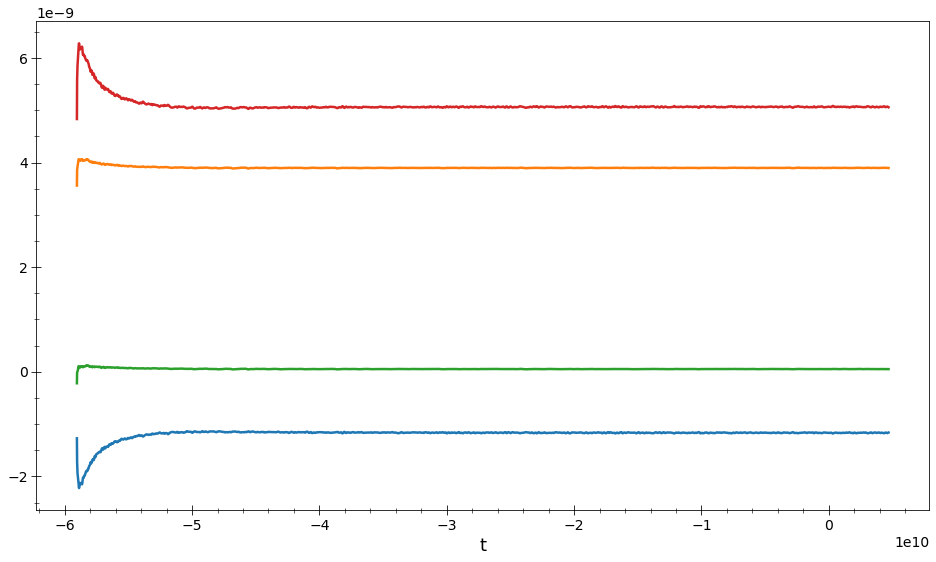

In [58]:
temp_3d = xr.zeros_like(ds[exp].ttrd_ldf)
temp_3d[:,0] += 1
(1/(9.81)*properties[exp].global_mean(temp_3d*dzg[exp]['zdf'],Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t')).plot()
(1/(9.81)*properties[exp].global_mean(temp_3d*dzg[exp]['zdf+qns'],Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t')).plot()
(1/(9.81)*properties[exp].global_mean(temp_3d*dzg[exp]['zdf+qns']+temp_3d*dzg[exp]['qsr'],Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t')).plot()
(dzg_gm[exp]['qns']).plot()

Text(0.5, 1.0, 'Spin-up adjustment')

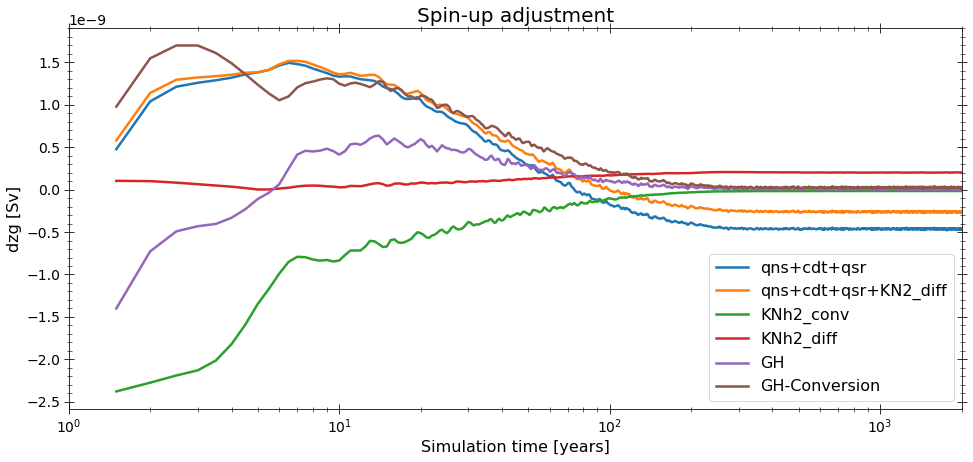

In [104]:
fig, ax = plt.subplots(figsize=(16,7))

x=np.linspace(1,2051,4100)
exp = exp_conv[0]
qns_cdt_roll = Gh_qns_cdt1[exp].rolling({'t':2}).mean('t')
qsr_roll = 1/(9.81)*qsr_gm[exp].rolling({'t':2}).mean('t')
Gh=dzg_gm[exp]['qsr']+dzg_gm[exp]['zdf+qns']+dzg_gm[exp]['ldf']+dzg_gm[exp]['cdt']

plt.plot(x,qns_cdt_roll+qsr_roll,label='qns+cdt+qsr')
plt.plot(x,qns_cdt_roll+qsr_roll+1/(9.81)*KN2_h_w_avt_inv_gm[exp].rolling({'t':2}).mean('t'),label='qns+cdt+qsr+KN2_diff')
#plt.plot(x,,label='KNh2_conv')
plt.plot(x,1/(9.81)*KN2_h_w_avt_gm[exp].rolling({'t':2}).mean('t'),label='KNh2_conv')
plt.plot(x,1/(9.81)*KN2_h_w_avt_inv_gm[exp].rolling({'t':2}).mean('t'),label='KNh2_diff')


C=-1/(9.81*1026)*properties[exp].global_mean(ds[exp].ketrd_convP2K,Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t')

plt.plot(x,Gh,label='GH')
plt.plot(x,Gh-(1/(9.81)*KN2_h_w_avt_gm[exp].rolling({'t':2}).mean('t')),label='GH-Conversion')

#plt.fill_between([0,10], -2.5e-9, 1.7e-9, alpha=0.6,color='grey')
#plt.fill_between([10,200], -2.5e-9, 1.7e-9,alpha=0.4,color='grey')
#plt.fill_between([200,3000], -2.5e-9, 1.7e-9,alpha=0.2,color='grey')

plt.xscale('log')
plt.xlim(1,2e3)
#plt.ylim(-2.5e-9, 1.7e-9)
plt.ylabel('dzg [Sv]',fontsize=16)
plt.xlabel('Simulation time [years]',fontsize=16)
ax.tick_params(top=True, right=True, which='both')
plt.legend(fontsize=16)
plt.title('Spin-up adjustment',fontsize=20)
#plt.savefig('figures/Fig4_spinup_tendencies_final.png', transparent=True, dpi=300)

Text(0.5, 1.0, 'Spin-up adjustment')

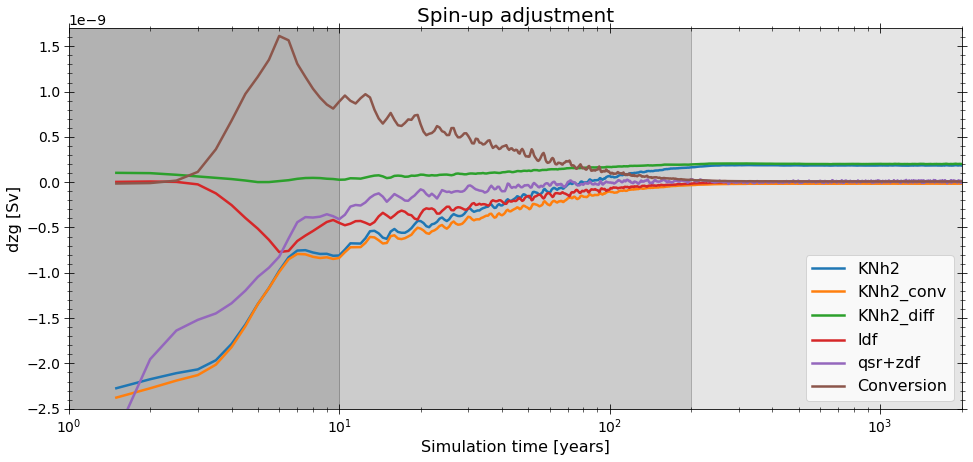

In [30]:
fig, ax = plt.subplots(figsize=(16,7))

x=np.linspace(1,2051,4100)
exp = exp_conv[0]
plt.plot(x,1/(9.81)*KN2_h_w_gm[exp].rolling({'t':2}).mean('t'),label='KNh2')
plt.plot(x,1/(9.81)*KN2_h_w_avt_gm[exp].rolling({'t':2}).mean('t'),label='KNh2_conv')
plt.plot(x,1/(9.81)*KN2_h_w_avt_inv_gm[exp].rolling({'t':2}).mean('t'),label='KNh2_diff')
plt.plot(x,dzg_gm[exp]['ldf'],label='ldf')
#plt.plot(x,dzg_gm[exp]['zdf'],label='zdf')
#plt.plot(x,dzg_gm[exp]['qsr'],label='qsr')
#plt.plot(x,dzg_gm[exp]['zdf+qns'],label='qsr+zdf')

plt.plot(x,dzg_gm[exp]['qsr']+dzg_gm[exp]['zdf+qns']+dzg_gm[exp]['ldf'],label='qsr+zdf')
plt.plot(x,1/(9.81*1026)*properties[exp].global_mean(ds[exp].ketrd_convP2K,Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t'),label='Conversion')

plt.fill_between([0,10], -2.5e-9, 1.7e-9, alpha=0.6,color='grey')
plt.fill_between([10,200], -2.5e-9, 1.7e-9,alpha=0.4,color='grey')
plt.fill_between([200,3000], -2.5e-9, 1.7e-9,alpha=0.2,color='grey')

plt.xscale('log')
plt.xlim(1,2e3)
plt.ylim(-2.5e-9, 1.7e-9)
plt.ylabel('dzg [Sv]',fontsize=16)
plt.xlabel('Simulation time [years]',fontsize=16)
ax.tick_params(top=True, right=True, which='both')
plt.legend(fontsize=16)
plt.title('Spin-up adjustment',fontsize=20)
#plt.savefig('figures/Fig4_spinup_tendencies_final.png', transparent=True, dpi=300)

In [27]:
exp = 'EXP00_rest6m2000_1'
Gh=(dzg[exp]['qsr']+dzg[exp]['zdf+qns']+dzg[exp]['ldf']+dzg[exp]['cdt']).compute()

/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


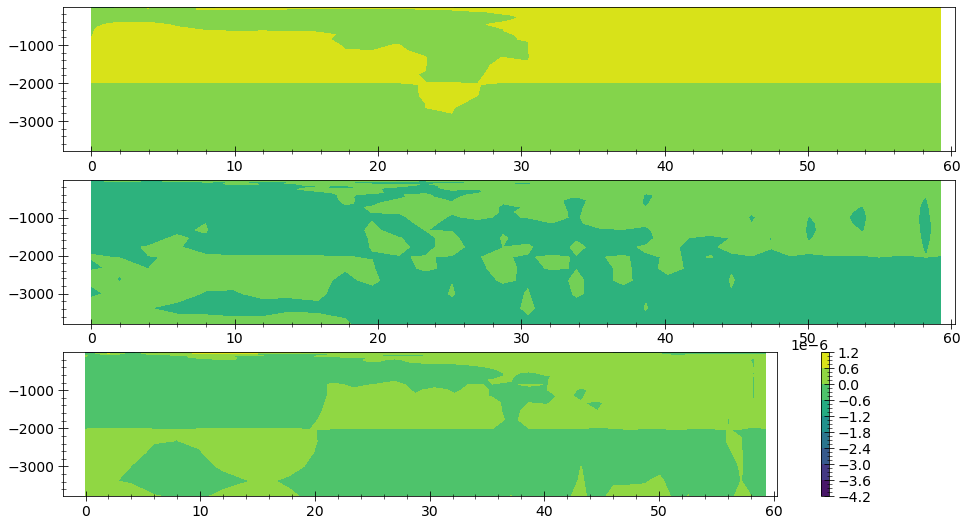

In [34]:
fig,ax = plt.subplots(3,figsize=(16,9))

exp = 'EXP00_rest6m2000_1'
phi = ds[exp].gphit[:,0]
lam = ds[exp].glamt[0,:]
depth = properties[exp].coords['Z']
YZ,ZY = np.meshgrid(phi.values,depth.values[:-1])
XY,YX = np.meshgrid(lam.values,phi.values)


cb = ax[0].contourf(YZ,ZY,grid_ops[exp].average(Gh, 'X')[1,:-1])
plt.colorbar(cb)
cb = ax[1].contourf(YZ,ZY,grid_ops[exp].average(Gh, 'X')[100,:-1])
plt.colorbar(cb)
cb = ax[2].contourf(YZ,ZY,grid_ops[exp].average(Gh, 'X')[1000,:-1])
plt.colorbar(cb)

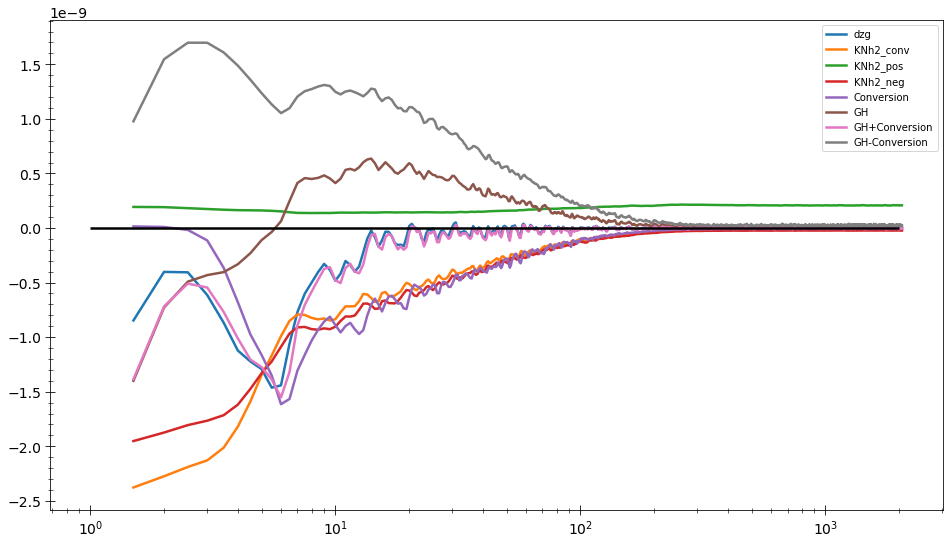

In [78]:
x=np.linspace(1,2051,4100)
exp = 'EXP00_rest6m2000_1'
dzg_tot=ds[exp].zgDE.diff('t').rolling({'t':2}).mean('t')/(60*60*24*360/2)
C=-1/(9.81*1026)*properties[exp].global_mean(ds[exp].ketrd_convP2K,Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t')
Gh=dzg_gm[exp]['qsr']+dzg_gm[exp]['zdf+qns']+dzg_gm[exp]['ldf']+dzg_gm[exp]['cdt']

plt.plot(x[:-1], dzg_tot, label='dzg')
plt.plot(x,1/(9.81)*KN2_h_w_avt_gm[exp].rolling({'t':2}).mean('t'),label='KNh2_conv')
plt.plot(x,1/(9.81)*KN2_positive_gm[exp].rolling({'t':2}).mean('t'),label='KNh2_pos')
plt.plot(x,1/(9.81)*KN2_negative_gm[exp].rolling({'t':2}).mean('t'),label='KNh2_neg')

plt.plot(x,C,label='Conversion')
plt.plot(x,Gh,label='GH')
plt.plot(x,Gh+C,label='GH+Conversion')
plt.plot(x,Gh-(1/(9.81)*KN2_h_w_avt_gm[exp].rolling({'t':2}).mean('t')),label='GH-Conversion')
plt.hlines(0,1,2000, colors='k')
plt.legend()
plt.xscale('log')

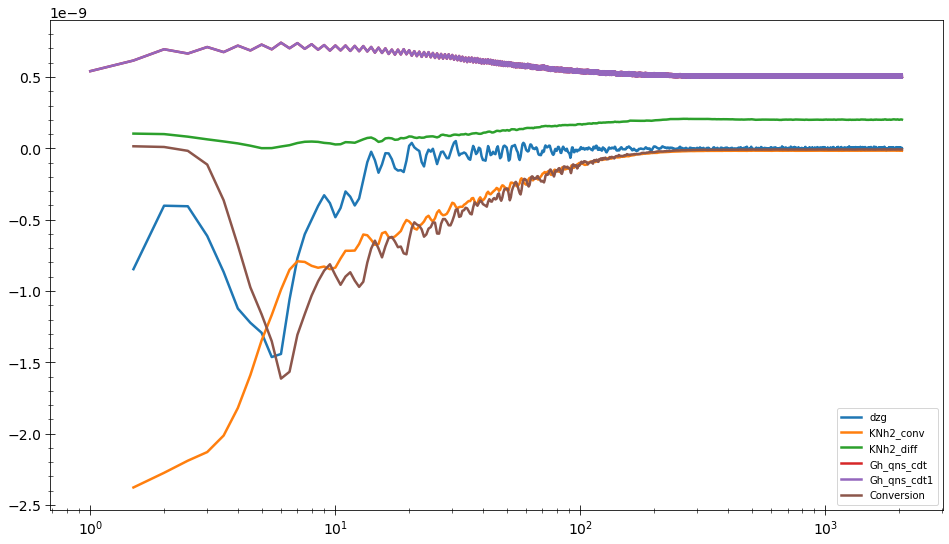

In [11]:
exp = 'EXP00_rest6m2000_1'
x=np.linspace(1,2051,4100)
dzg_tot=ds[exp].zgDE.diff('t').rolling({'t':2}).mean('t')/(60*60*24*360/2)
C=-1/(9.81*1026)*properties[exp].global_mean(ds[exp].ketrd_convP2K,Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t')
#Gh=dzg_gm[exp]['qsr']+dzg_gm[exp]['zdf+qns']+dzg_gm[exp]['ldf']+dzg_gm[exp]['cdt']

plt.plot(x[:-1], dzg_tot, label='dzg')
plt.plot(x,1/(9.81)*KN2_h_w_avt_gm[exp].rolling({'t':2}).mean('t'),label='KNh2_conv')
#plt.plot(x,1/(9.81)*KN2_h_w_avt_gm1[exp].rolling({'t':2}).mean('t'),label='KNh2_conv1')
plt.plot(x,1/(9.81)*KN2_h_w_avt_inv_gm[exp].rolling({'t':2}).mean('t'),label='KNh2_diff')
plt.plot(x, Gh_qns[exp]/4000,label='Gh_qns_cdt')
plt.plot(x, 1/10*Gh_qns_cdt1[exp],label='Gh_qns_cdt1')
#plt.plot(x,1/(9.81)*KN2_h_w_avt_inv_gm1[exp].rolling({'t':2}).mean('t'),label='KNh2_diff1')

plt.plot(x,C,label='Conversion')
#plt.plot(x,Gh,label='GH')
#plt.plot(x,Gh+C,label='GH+Conversion')

plt.legend()
plt.xscale('log')

In [ ]:
fig, ax = plt.subplots(figsize=(16,7))

x=np.linspace(1,2051,4100)
exp = exp_conv[0]
plt.plot(x,1/(9.81)*KN2_h_w_gm[exp].rolling({'t':2}).mean('t'),label='KNh2')
plt.plot(x,1/(9.81)*KN2_h_w_avt_gm[exp].rolling({'t':2}).mean('t'),label='KNh2_conv')
plt.plot(x,1/(9.81)*KN2_h_w_avt_inv_gm[exp].rolling({'t':2}).mean('t'),label='KNh2_diff')
plt.plot(x,dzg_gm[exp]['ldf'],label='ldf')
#plt.plot(x,dzg_gm[exp]['zdf'],label='zdf')
#plt.plot(x,dzg_gm[exp]['qsr'],label='qsr')
#plt.plot(x,dzg_gm[exp]['zdf+qns'],label='qsr+zdf')

plt.plot(x,dzg_gm[exp]['qsr']+dzg_gm[exp]['zdf+qns']+dzg_gm[exp]['ldf'],label='qsr+zdf+ldf')
plt.plot(x,1/(9.81*1026)*properties[exp].global_mean(ds[exp].ketrd_convP2K,Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t'),label='Conversion')

plt.fill_between([0,10], -2.5e-9, 1.7e-9, alpha=0.6,color='grey')
plt.fill_between([10,200], -2.5e-9, 1.7e-9,alpha=0.4,color='grey')
plt.fill_between([200,3000], -2.5e-9, 1.7e-9,alpha=0.2,color='grey')

plt.xscale('log')
plt.xlim(1,2e3)
plt.ylim(-2.5e-9, 1.7e-9)
plt.ylabel('dzg [Sv]',fontsize=16)
plt.xlabel('Simulation time [years]',fontsize=16)
ax.tick_params(top=True, right=True, which='both')
plt.legend(fontsize=16)
plt.title('Spin-up adjustment',fontsize=20)
#plt.savefig('figures/Fig4_spinup_tendencies_final.png', transparent=True, dpi=300)

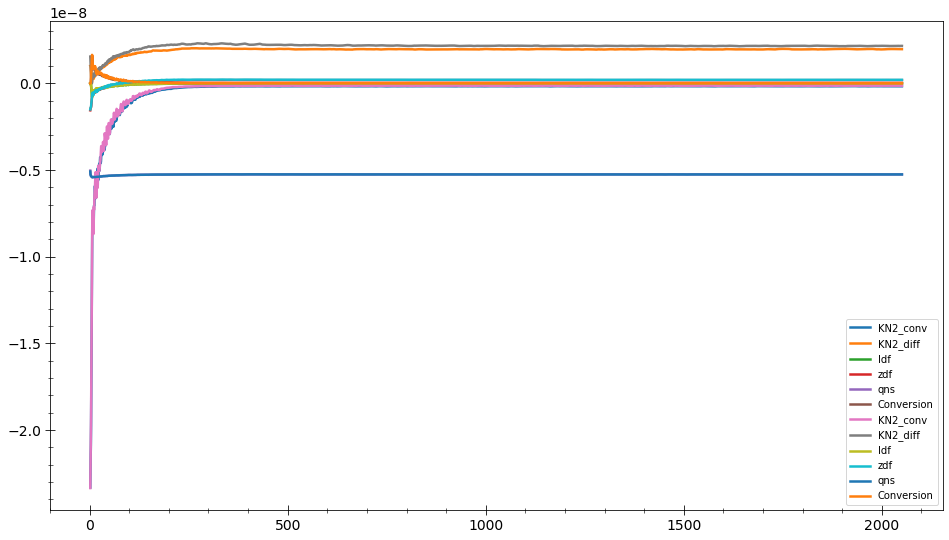

In [8]:
x=np.linspace(1,2051,4100)
for exp in exp_conv:
    plt.plot(x,KN2_h_w_avt_gm[exp].rolling({'t':2}).mean('t'),label='KN2_conv')
    plt.plot(x,KN2_h_w_avt_inv_gm[exp].rolling({'t':2}).mean('t'),label='KN2_diff')
    plt.plot(x,1/(9.81)*properties[exp].global_mean(dzg[exp]['ldf'],Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t'),label='ldf')
    plt.plot(x,1/(9.81)*properties[exp].global_mean(dzg[exp]['zdf'],Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t'),label='zdf')
    plt.plot(x,1/(9.81)*properties[exp].global_mean(dzg[exp]['qsr'],Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t'),label='qns')
    plt.plot(x,1/(9.81*1026)*properties[exp].global_mean(ds[exp].ketrd_convP2K,Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t'),label='Conversion')
plt.legend()
#plt.xlim(1500,2000)
#plt.ylim(-.25e-9,.25e-9)

Text(0.5, 1.0, 'Spin-up adjustment')

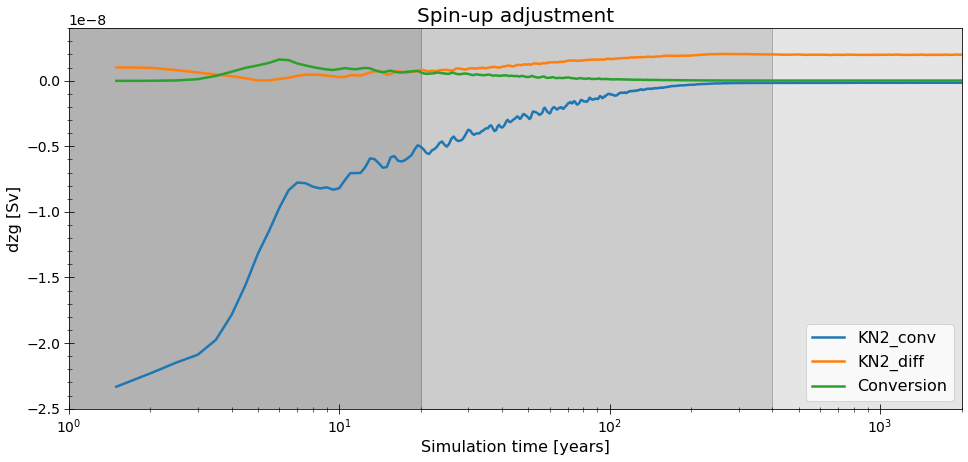

In [48]:
fig,ax = plt.subplots(figsize=(16,7))

x=np.linspace(1,2051,4100)

exp=exp_conv[0]
KN2_h_w_avt_gm[exp]
ax.plot(x,,label='KN2_conv')
ax.plot(x,KN2_h_w_avt_inv_gm[exp].rolling({'t':2}).mean('t'),label='KN2_diff')
ax.plot(x,1/(9.81*1026)*properties[exp].global_mean(ds[exp].ketrd_convP2K,Vmask=ds[exp].mask_bd_t).rolling({'t':2}).mean('t'),label='Conversion')

#ax.fill_between(range(len(s)), 0, max(zg[sim[0]]), where=(s < 1.25) & (s > 0.75), alpha=0.5)
ax.fill_between([0,20], -2.5e-8, 0.4e-8, alpha=0.6,color='grey')
ax.fill_between([20,400], -2.5e-8, 0.4e-8,alpha=0.4,color='grey')
ax.fill_between([400,3000], -2.5e-8, 1e-8,alpha=0.2,color='grey')

ax.set_xscale('log')
ax.set_xlim(1,2e3)
ax.set_ylim(-2.5e-8, 0.4e-8)
ax.set_ylabel('dzg [Sv]',fontsize=16)
ax.set_xlabel('Simulation time [years]',fontsize=16)
plt.legend(fontsize=16)
ax.set_title('Spin-up adjustment',fontsize=20)

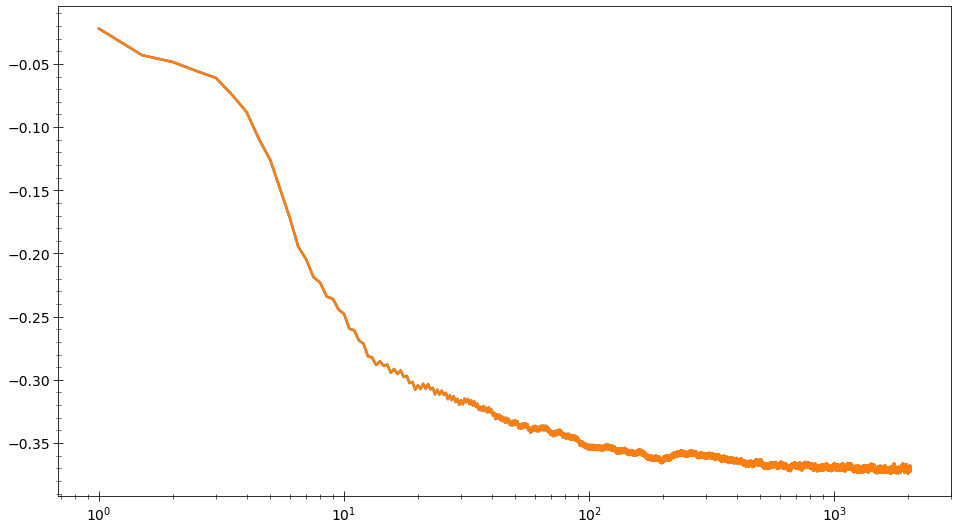

In [6]:
x=np.linspace(1,2051,4100)
plt.plot(x,ds['EXP00_rest6m2000'].zgDE)
plt.plot(x,ds['EXP00_rest6m2000_1'].zgDE)
#plt.plot(x,ds['EXP00_rest6m2000'].zgDE_gm)

#plt.plot(x,ds['EXP00_rest6m2000'].zgDE-ds['EXP00_rest6m2000'].zgDE_gm)
#ax2 = plt.twinx()
#ax2.plot(x,ds['EXP00_rest6m2000'].psi_dmoc)
plt.xscale('log')

In [21]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats

dt=ds['EXP00_rest6m2000_1'].t.diff('t')[0]/86400/360
t_years=np.arange(1,(len(ds['EXP00_rest6m2000_1'].t)+2)*dt,dt)

Text(0.5, 1.0, 'Spin-up adjustment')

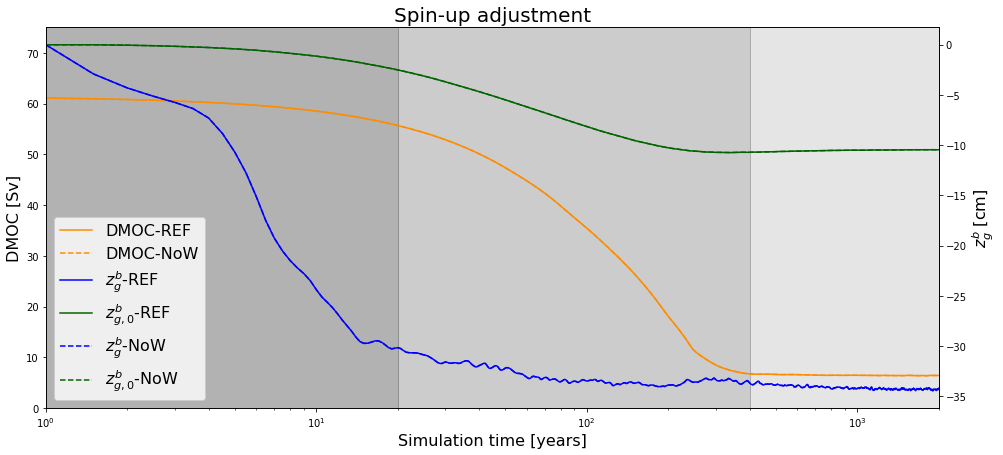

In [7]:
fig,ax = plt.subplots(figsize=(16,7))
exp = 'EXP00_rest6m2000'
exp1 = 'EXP01_rest6m2000'

zg =   {exp: ds[exp].zgDE.rolling({'t':2}).mean('t') for exp in ds}
zg0 =   {exp: ds[exp].zgDE_gm.rolling({'t':2}).mean('t') for exp in ds}
for exp in ds: zg[exp][0]=0; zg0[exp][0]=0
dmoc = {exp: np.transpose(lowess(ds[exp].psi_dmoc.values, ds[exp].t,frac=0.05))[1] for exp in ds}
#ax.plot(t_years,ds[exp].psi_dmoc,c='dimgrey',label='DMOC-REF')
#ax.plot(t_years,ds[exp].psi_dmoc,c='dimgrey',linestyle='--',label='DMOC-NoW')
ax.plot(t_years,dmoc[exp],c='Darkorange',label='DMOC-REF')
ax.plot(t_years,dmoc[exp1],c='Darkorange',linestyle='--',label='DMOC-NoW')

#ax.fill_between(range(len(s)), 0, max(zg[sim[0]]), where=(s < 1.25) & (s > 0.75), alpha=0.5)
ax.fill_between([0,20], 75,alpha=0.6,color='grey')
ax.fill_between([20,400], 75,alpha=0.4,color='grey')
ax.fill_between([400,3000], 75,alpha=0.2,color='grey')

ax0=ax.twinx()
z=ax0.plot(t_years,zg[exp]*100,c='b',label='$z_g^b$-REF')
z=ax0.plot(t_years,zg0[exp]*100,c='Darkgreen',label='$z_{g,0}^b$-REF')
z=ax0.plot(t_years,zg[exp1]*100,c='b',linestyle='--',label='$z_g^b$-NoW')
z=ax0.plot(t_years,zg0[exp1]*100,c='Darkgreen',linestyle='--',label='$z_{g,0}^b$-NoW')

ax.set_xscale('log')
ax.set_xlim(1,2e3)
ax.set_ylim(0,75)
ax.set_ylabel('DMOC [Sv]',fontsize=16)
ax0.set_ylabel('$z_g^b$ [cm]',fontsize=16)
ax.set_xlabel('Simulation time [years]',fontsize=16)
plt.legend(ax.get_legend_handles_labels()[0]+ax0.get_legend_handles_labels()[0],
          ax.get_legend_handles_labels()[1]+ax0.get_legend_handles_labels()[1],fontsize=16)
ax.set_title('Spin-up adjustment',fontsize=20)
#plt.savefig('Figures/Fig3_0to2000_v2.png', dpi=150, transparent=True, bbox_inches='tight')

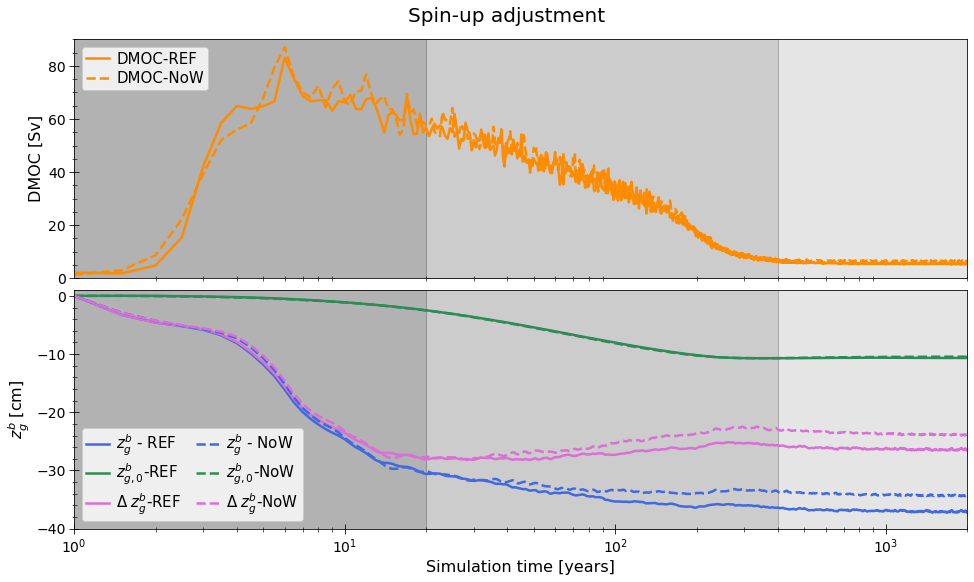

In [ ]:
fig,ax = plt.subplots(2,figsize=(16,9))
exp0 = 'EXP00_rest6m2000'
exp1 = 'EXP01_rest6m2000'

zg =   {exp: ds[exp].zgDE.rolling({'t':2}).mean('t') for exp in ds}
zg0 =   {exp: ds[exp].zgDE_gm.rolling({'t':2}).mean('t') for exp in ds}
for exp in ds: zg[exp][0]=0; zg0[exp][0]=0
dmoc = {exp: np.transpose(lowess(ds[exp].psi_dmoc.values, ds[exp].t,frac=0.001))[1] for exp in ds}


#ax.plot(t_years,ds[exp].psi_dmoc,c='dimgrey',label='DMOC-REF')
#ax.plot(t_years,ds[exp].psi_dmoc,c='dimgrey',linestyle='--',label='DMOC-NoW')
ax[0].plot(t_years,dmoc[exp0],c='Darkorange',label='DMOC-REF')
ax[0].plot(t_years,dmoc[exp1],c='Darkorange',linestyle='--',label='DMOC-NoW')
ax[0].legend(fontsize=15,loc='upper left',borderpad=0.3,handlelength=1.5,handletextpad=0.5,labelspacing=0.3)

ax[0].fill_between([0,20], 90,alpha=0.6,color='grey')
ax[0].fill_between([20,400], 90,alpha=0.4,color='grey')
ax[0].fill_between([400,3000], 90,alpha=0.2,color='grey')


ax[1].plot(t_years,zg[exp0]*100,c='royalblue',label='$z_g^b$ - REF')
ax[1].plot(t_years,zg0[exp0]*100,c='seagreen',label='$z_{g,0}^b$-REF')
ax[1].plot(t_years,(zg[exp0]-zg0[exp0])*100,c='orchid',label='$\Delta\; z_{g}^b$-REF')

ax[1].plot(t_years,zg[exp1]*100,c='royalblue',linestyle='--',label='$z_g^b$ - NoW')
ax[1].plot(t_years,zg0[exp1]*100,c='seagreen',linestyle='--',label='$z_{g,0}^b$-NoW')
ax[1].plot(t_years,(zg[exp1]-zg0[exp1])*100,c='orchid',linestyle='--',label='$\Delta\; z_{g}^b$-NoW')

ax[1].legend(fontsize=15,loc='lower left',borderpad=0.3,handlelength=1.5,handletextpad=0.5,labelspacing=0.3,ncol=2,columnspacing=1)

ax[1].fill_between([0,20], -40,1,alpha=0.6,color='grey')
ax[1].fill_between([20,400], -40,1,alpha=0.4,color='grey')
ax[1].fill_between([400,3000], -40,1,alpha=0.2,color='grey')


for i in range(2):
    ax[i].set_xscale('log')
    ax[i].set_xlim(1,2e3)
ax[0].set_ylim(0,90)
ax[0].set_ylabel('DMOC [Sv]',fontsize=16)
ax[0].set_xticks([])
ax[1].set_ylim(-40,1)
ax[1].set_ylabel('$z_g^b$ [cm]',fontsize=16)
ax[1].set_xlabel('Simulation time [years]',fontsize=16)
ax[1].set_yticks(ax[1].get_yticks()[:-1])
plt.subplots_adjust(hspace=0.05)
fig.suptitle('Spin-up adjustment',fontsize=20,y=0.93)
plt.savefig('figures/Fig4_spinup_final.png', dpi=150, transparent=True, bbox_inches='tight')

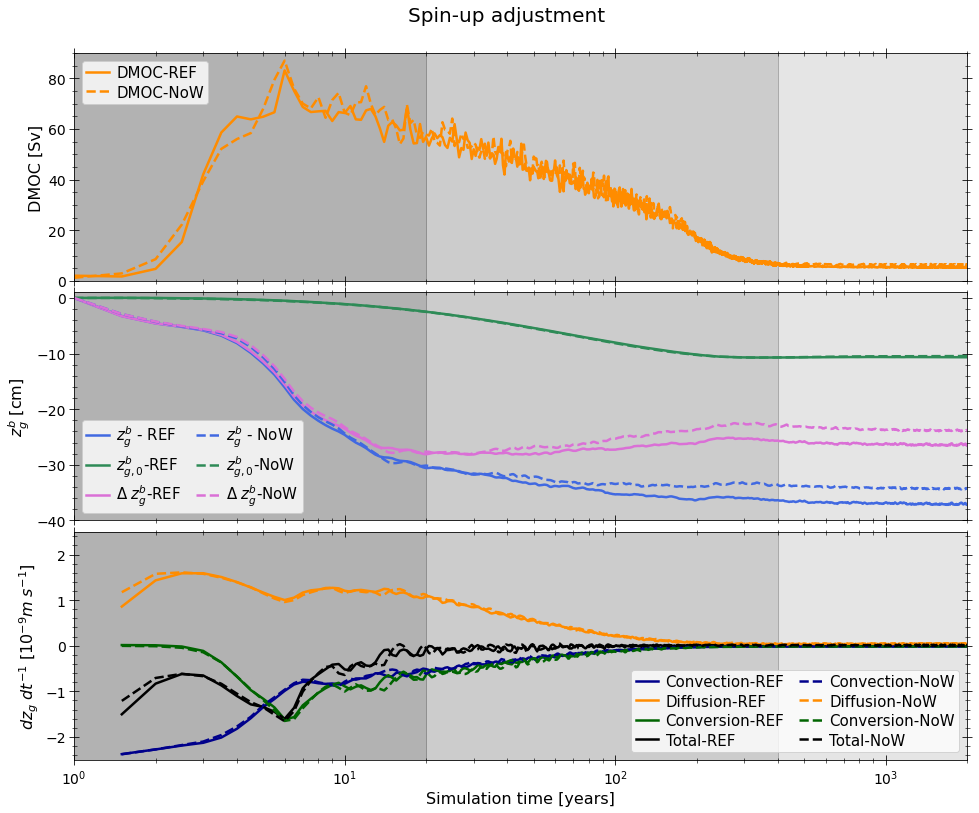

In [31]:
fig,ax = plt.subplots(3,figsize=(16,13))
for i, range in enumerate([[0,90],[-40,1],[-2.5,2.5]]):
    ax[i].fill_between([0,20], range[0], range[1],alpha=0.6,color='grey')
    ax[i].fill_between([20,400], range[0], range[1],alpha=0.4,color='grey')
    ax[i].fill_between([400,3000], range[0], range[1],alpha=0.2,color='grey')

    ax[i].set_xscale('log')
    ax[i].set_xlim(1,2e3)
    ax[i].set_ylim(range[0], range[1])
    if i<2: ax[i].set_xticklabels([])
    ax[i].tick_params(top=True, right=True, which='both')
    if i==2: ax[i].set_xlabel('Simulation time [years]',fontsize=16)

plt.subplots_adjust(hspace=0.05)
fig.suptitle('Spin-up adjustment',fontsize=20,y=0.93)

exp0 = 'EXP00_rest6m2000_1'
exp1 = 'EXP01_rest6m2000_1'

# DMOC
dmoc = {exp: np.transpose(lowess(ds[exp].psi_dmoc.values, ds[exp].t,frac=0.001))[1] for exp in ds}
ax[0].plot(t_years,dmoc[exp0],c='Darkorange',label='DMOC-REF')
ax[0].plot(t_years,dmoc[exp1],c='Darkorange',linestyle='--',label='DMOC-NoW')
ax[0].legend(fontsize=15,loc='upper left',borderpad=0.3,handlelength=1.5,handletextpad=0.5,labelspacing=0.3)
ax[0].set_ylabel('DMOC [Sv]',fontsize=16)

# Zg
zg =   {exp: ds[exp].zgDE.rolling({'t':2}).mean('t') for exp in ds}
zg0 =   {exp: ds[exp].zgDE_gm.rolling({'t':2}).mean('t') for exp in ds}
for exp in ds: zg[exp][0]=0; zg0[exp][0]=0

ax[1].plot(t_years,zg[exp0]*100,c='royalblue',label='$z_g^b$ - REF')
ax[1].plot(t_years,zg0[exp0]*100,c='seagreen',label='$z_{g,0}^b$-REF')
ax[1].plot(t_years,(zg[exp0]-zg0[exp0])*100,c='orchid',label='$\Delta\; z_{g}^b$-REF')
ax[1].plot(t_years,zg[exp1]*100,c='royalblue',linestyle='--',label='$z_g^b$ - NoW')
ax[1].plot(t_years,zg0[exp1]*100,c='seagreen',linestyle='--',label='$z_{g,0}^b$-NoW')
ax[1].plot(t_years,(zg[exp1]-zg0[exp1])*100,c='orchid',linestyle='--',label='$\Delta\; z_{g}^b$-NoW')

ax[1].legend(fontsize=15,loc='lower left',borderpad=0.3,handlelength=1.5,handletextpad=0.5,labelspacing=0.3,ncol=2,columnspacing=1)
ax[1].set_ylabel('$z_g^b$ [cm]',fontsize=16)
ax[1].set_yticks(ax[1].get_yticks()[:-1])

# dzg
magn=1e9
x=np.linspace(1,2051,4100)

KN2_convective = 1/(9.81)*KN2_h_bot_to_top_convective_gm[exp0].rolling({'t':2}).mean('t').compute()
KN2_diffusive = 1/(9.81)*KN2_h_bot_to_top_diffusive_gm[exp0].rolling({'t':2}).mean('t').compute()
Gh_surf = 1/(9.81)*(GhT_surfaceflux[exp0]+GhS_surfaceflux[exp0]).rolling({'t':2}).mean('t').compute()
Gh_hdiff = 1/(9.81)*(GhT_hdiffusion[exp0]+GhS_hdiffusion[exp0]).rolling({'t':2}).mean('t').compute()
Gh_qsr = 1/(9.81)*(GhT_qsr[exp0]).rolling({'t':2}).mean('t').compute()
C=-1/(9.81*1026)*properties[exp0].global_mean(ds[exp0].ketrd_convP2K,Vmask=ds[exp0].mask_bd_t).rolling({'t':2}).mean('t').compute()

ax[2].plot(x,-KN2_convective*magn,label='Convection-REF', c='darkblue')
ax[2].plot(x,(-KN2_diffusive+Gh_qsr+Gh_surf+Gh_hdiff)*magn,label='Diffusion-REF', c='darkorange')
ax[2].plot(x, C*magn, label='Conversion-REF', c='darkgreen')
ax[2].plot(x,(- KN2_convective - KN2_diffusive + Gh_surf + Gh_hdiff + Gh_qsr + C)*magn , label='Total-REF', c='k')

KN2_convective = 1/(9.81)*KN2_h_bot_to_top_convective_gm[exp1].rolling({'t':2}).mean('t').compute()
KN2_diffusive = 1/(9.81)*KN2_h_bot_to_top_diffusive_gm[exp1].rolling({'t':2}).mean('t').compute()
Gh_surf = 1/(9.81)*(GhT_surfaceflux[exp1]+GhS_surfaceflux[exp1]).rolling({'t':2}).mean('t').compute()
Gh_hdiff = 1/(9.81)*(GhT_hdiffusion[exp1]+GhS_hdiffusion[exp1]).rolling({'t':2}).mean('t').compute()
Gh_qsr = 1/(9.81)*(GhT_qsr[exp1]).rolling({'t':2}).mean('t').compute()
C=-1/(9.81*1026)*properties[exp1].global_mean(ds[exp1].ketrd_convP2K,Vmask=ds[exp1].mask_bd_t).rolling({'t':2}).mean('t').compute()

ax[2].plot(x,(-KN2_convective)*magn,label='Convection-NoW', c='darkblue',linestyle='--')
ax[2].plot(x,(-KN2_diffusive+Gh_qsr+Gh_surf+Gh_hdiff)*magn,label='Diffusion-NoW', c='darkorange',linestyle='--')
ax[2].plot(x, C*magn, label='Conversion-NoW', c='darkgreen',linestyle='--')
ax[2].plot(x,(- KN2_convective - KN2_diffusive + Gh_surf +Gh_hdiff + Gh_qsr + C)*magn , label='Total-NoW', c='k', linestyle='--')

ax[2].set_ylabel('$dz_g\;dt^{-1}$ $[10^{-9} m\;s^{-1}]$',fontsize=16)
ax[2].legend(fontsize=15,loc='lower right',borderpad=0.3,handlelength=1.5,handletextpad=0.5,labelspacing=0.3,ncol=2,columnspacing=1)

plt.savefig('figures/Fig5_6_spinup_comb_final.png', transparent=True, dpi=300)